In [522]:
import pandas  as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import numpy as np
import seaborn as sns
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
import sklearn
from sklearn import preprocessing
from scipy.stats.mstats import winsorize
from scipy.stats import iqr
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import Counter
import matplotlib.gridspec as gridspec

In [523]:
import utils

In [524]:
import pickle
with open('mouse_set_1_data.pkl', 'rb') as f:
    mouse_1 = pickle.load(f)

with open('mouse_set_2_data.pkl', 'rb') as f:
    mouse_2 = pickle.load(f)

def get_mouse_data(mouse_num, column):
    """ helper function to get mouse data """
    if mouse_num <= 5:
        # dict 1
        if column in['reads','qpcr']:
            return mouse_1[column][str(mouse_num)]
        else:
            return mouse_1[column]
    else:
        # dict 2
        if column in['reads','qpcr']:
            return mouse_2[column][str(mouse_num)]
        else:
            return mouse_2[column]

# Preprocessing the data for some plotting
data = {}
for mouse in range(2,11):
  data[mouse]={}
  for sort_data in ['reads', 'qpcr', 'times', 'otu_taxonomy']:
    data[mouse][sort_data] = get_mouse_data(mouse, sort_data)
  data[mouse]['reads_perc']=data[mouse]['reads'].copy()
  data[mouse]['reads_quant_mean']=data[mouse]['reads'].copy()
  data[mouse]['reads_quant_std']=data[mouse]['reads'].copy()
  for t in data[mouse]['reads'].keys():
    summation_at_time_point = (data[mouse]['reads'][t]).sum()
    data[mouse]['reads_perc'][t] = data[mouse]['reads'][t]/summation_at_time_point
    data[mouse]['reads_quant_mean'][t] = data[mouse]['reads_perc'][t]*data[mouse]['qpcr']['mean'][t]
    data[mouse]['reads_quant_std'][t]  = data[mouse]['reads_perc'][t]*data[mouse]['qpcr']['std'][t]
    quant_perc = data[mouse]['reads_quant_mean'].values
    quant_perc = np.sum(quant_perc, axis=1)
    data[mouse]['contribution'] = quant_perc/quant_perc.sum()

# Raw Data

In [525]:
mice = utils.load_data()

In [526]:
test = mice[2]

In [527]:
df = pd.DataFrame(test['reads_standardized'][:20,:].transpose())

In [528]:
df.columns = test['otus'][:20]

In [529]:
df.head()

,OTU_1,OTU_2,OTU_3,OTU_4,OTU_5,OTU_6,OTU_7,OTU_8,OTU_9,OTU_10,OTU_11,OTU_12,OTU_13,OTU_14,OTU_15,OTU_16,OTU_17,OTU_18,OTU_19,OTU_20
0,-0.671932,-0.555061,-0.153682,-0.793824,-0.602807,-0.770774,-0.671822,-0.444396,-0.161739,-0.613331,-0.150249,-0.752429,-0.679769,-0.663008,-0.300794,-0.761214,-0.790862,-0.410746,-0.608066,-0.464911
1,-0.670615,-0.554683,-0.153681,-0.793825,-0.602805,-0.770774,-0.671731,-0.444388,-0.154256,-0.613322,-0.148904,-0.752437,-0.679945,-0.663053,-0.300846,-0.761214,-0.790862,-0.410746,-0.608073,-0.464911
2,0.986956,0.770593,-0.129003,-0.788692,-0.529966,-0.768710,0.402389,0.157486,-0.163240,4.139698,-0.150288,0.101391,6.131324,2.678385,5.556467,-0.751894,-0.790862,-0.410746,-0.486310,-0.464911
3,-0.667879,-0.447445,-0.152080,-0.793384,-0.598137,-0.770625,-0.595656,-0.389522,-0.152266,-0.375504,-0.150288,-0.681768,-0.401161,-0.359186,-0.129382,-0.760989,-0.790862,-0.410746,-0.591939,-0.464911
4,-0.664473,-0.381504,-0.148601,-0.791765,-0.597910,-0.769483,-0.540818,-0.321498,-0.144047,-0.539764,-0.145107,-0.598856,-0.475370,-0.397366,-0.220060,-0.756246,-0.777477,-0.410746,-0.564915,-0.464911


Show stats

In [530]:
df.describe()

,OTU_1,OTU_2,OTU_3,OTU_4,OTU_5,OTU_6,OTU_7,OTU_8,OTU_9,OTU_10,OTU_11,OTU_12,OTU_13,OTU_14,OTU_15,OTU_16,OTU_17,OTU_18,OTU_19,OTU_20
count,7.500000e+01,7.500000e+01,7.500000e+01,7.500000e+01,7.500000e+01,7.500000e+01,7.500000e+01,7.500000e+01,7.500000e+01,7.500000e+01,7.500000e+01,7.500000e+01,7.500000e+01,7.500000e+01,7.500000e+01,7.500000e+01,7.500000e+01,7.500000e+01,7.500000e+01,7.500000e+01
mean,-1.602422e-16,-1.036208e-17,2.220446e-18,-2.368476e-17,3.049413e-16,-2.072416e-17,-1.421085e-16,1.628327e-17,-3.330669e-17,-2.960595e-18,-3.922788e-17,-1.406282e-17,-2.368476e-17,-1.125026e-16,-3.552714e-17,1.791160e-16,-1.361874e-16,-1.184238e-17,-2.893981e-16,2.664535e-17
std,1.006734e+00,1.006734e+00,1.006734e+00,1.006734e+00,1.006734e+00,1.006734e+00,1.006734e+00,1.006734e+00,1.006734e+00,1.006734e+00,1.006734e+00,1.006734e+00,1.006734e+00,1.006734e+00,1.006734e+00,1.006734e+00,1.006734e+00,1.006734e+00,1.006734e+00,1.006734e+00
min,-6.719322e-01,-5.551274e-01,-1.536915e-01,-7.938249e-01,-6.028075e-01,-7.707744e-01,-6.718555e-01,-4.444101e-01,-1.632399e-01,-6.134222e-01,-1.502876e-01,-7.524373e-01,-6.799451e-01,-6.630684e-01,-3.008478e-01,-7.612145e-01,-7.908617e-01,-4.107461e-01,-6.080771e-01,-4.649114e-01
25%,-6.533588e-01,-5.375292e-01,-1.489082e-01,-6.853916e-01,-6.025604e-01,-7.071547e-01,-6.539266e-01,-4.444032e-01,-1.632399e-01,-5.692692e-01,-1.502876e-01,-5.932677e-01,-5.713651e-01,-6.626961e-01,-3.003218e-01,-6.465309e-01,-6.060904e-01,-4.106289e-01,-5.455372e-01,-4.649114e-01
50%,-3.570468e-01,-4.570125e-01,-1.370449e-01,-3.885149e-01,-5.299656e-01,-5.021428e-01,-5.181358e-01,-4.228814e-01,-1.542445e-01,-4.476593e-01,-1.455326e-01,-4.073084e-01,-2.985263e-01,-5.490393e-01,-2.972002e-01,-2.863935e-01,-4.239974e-01,-4.009207e-01,-4.246172e-01,-4.387363e-01
75%,1.902945e-01,-9.277553e-02,-1.028598e-01,3.239647e-01,-2.776916e-02,5.224290e-01,1.612289e-01,-8.561570e-02,-1.146749e-01,1.681100e-01,-1.320516e-01,2.040709e-01,1.309498e-01,2.991741e-01,-2.258230e-01,2.299976e-01,2.173341e-01,-2.344671e-01,7.369245e-02,-1.443344e-01
max,5.332961e+00,3.493666e+00,8.590137e+00,4.115222e+00,3.489782e+00,4.223142e+00,3.882308e+00,4.805640e+00,8.542671e+00,4.139698e+00,8.547539e+00,5.285151e+00,6.131324e+00,3.929445e+00,5.556467e+00,5.021546e+00,4.363989e+00,4.998351e+00,4.496910e+00,5.085912e+00


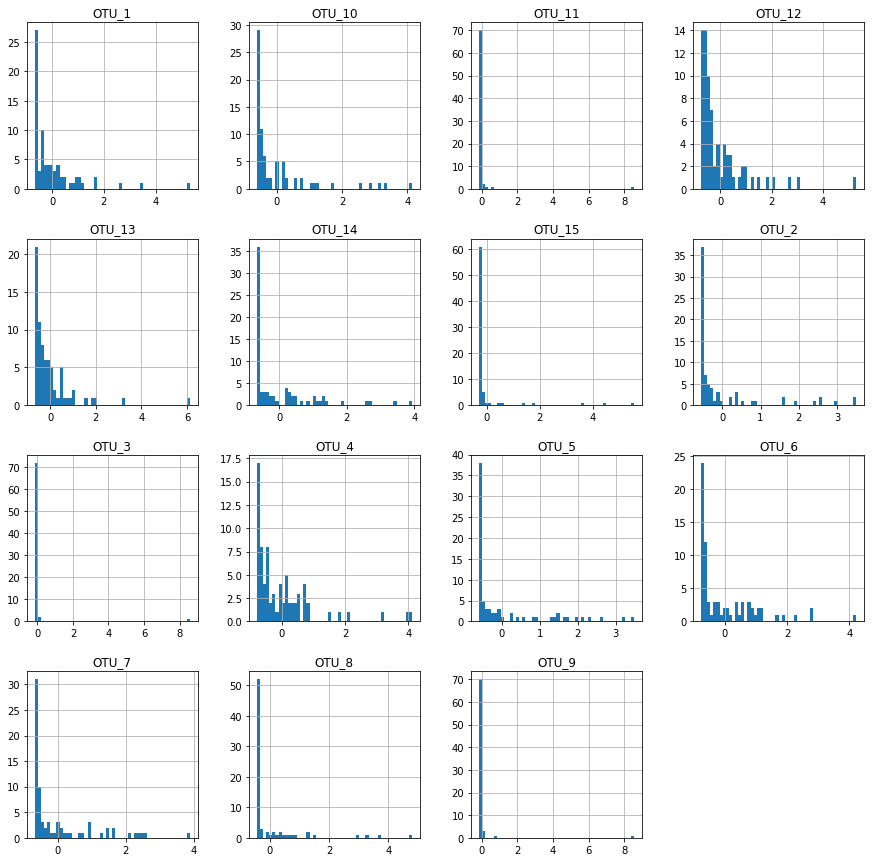

In [531]:
df.iloc[:,:15].hist(bins=50, figsize=(15,15))
plt.show()

Apply ADF fuller test

In [532]:
results = df.apply(adfuller)

In [533]:
adf_results = list(results.apply(lambda x:x[0]))
pval_results = list(results.apply(lambda x:x[1]))
critic = list(results.apply(lambda x:x[4]['5%']))
indexes = [i for i in range(len(critic))]

In [534]:
pval_results, adf_results, critic, indexes = zip(*sorted(zip(pval_results, adf_results, critic, indexes)))

In [535]:
pval_results=np.array(pval_results)
adf_results=np.array(adf_results)



good_indexes = pval_results<0.05
good_pval = pval_results[good_indexes]

bad_indexes = pval_results>=0.05
bad_pval= pval_results[bad_indexes]

good_adf = adf_results[good_indexes]
bad_adf = adf_results[bad_indexes]

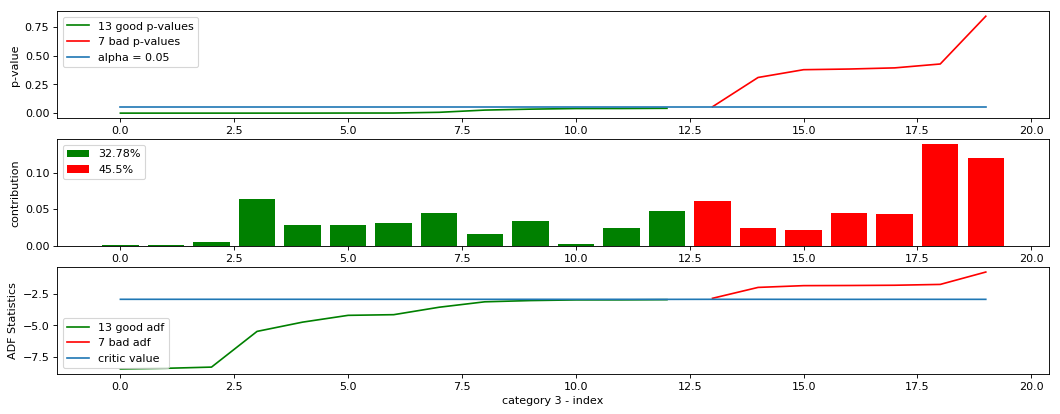

In [536]:
# Draw Plot
fig = plt.figure(figsize=(16,6), dpi=80)

ax1 = fig.add_subplot(311)
plt.plot(good_pval, color='g', label = '{} good p-values'.format(good_pval.shape[0]))
plt.plot(range(good_pval.shape[0],len(pval_results)),bad_pval, color='r', label = '{} bad p-values'.format(bad_pval.shape[0]))
plt.plot(range(len(pval_results)),[0.05]*len(pval_results), label='alpha = 0.05')
plt.ylabel('p-value')
plt.legend()


ax2 = fig.add_subplot(312, sharex=ax1)
n_good = good_indexes.astype(int).sum()
tot_good = data[2]['contribution'][list(indexes)][good_indexes].sum()
plt.bar(range(n_good),data[2]['contribution'][list(indexes)][good_indexes], color='green', label='{}%'.format(round(tot_good*100,2)))

n_bad= bad_indexes.astype(int).sum()
tot_bad = data[2]['contribution'][list(indexes)][bad_indexes].sum()
plt.bar(range(n_good, n_good+n_bad),data[2]['contribution'][list(indexes)][bad_indexes], color='red', label='{}%'.format(round(tot_bad*100,2)))

plt.ylabel('contribution')
plt.legend()

ax3 = fig.add_subplot(313, sharex=ax1)
plt.plot(good_adf, color='g', label = '{} good adf'.format(good_adf.shape[0]))
plt.plot(range(good_adf.shape[0],len(adf_results)),bad_adf, color='r', label = '{} bad adf'.format(bad_adf.shape[0]))
plt.plot(critic, label='critic value')

plt.ylabel('ADF Statistics')
plt.xlabel('category 3 - index')

plt.legend()
plt.show()

# Correlation matrix

In [537]:
# Plot
plt.figure(figsize=(12,12), dpi= 80)
corr_matrix = df.corr()

<Figure size 960x960 with 0 Axes>

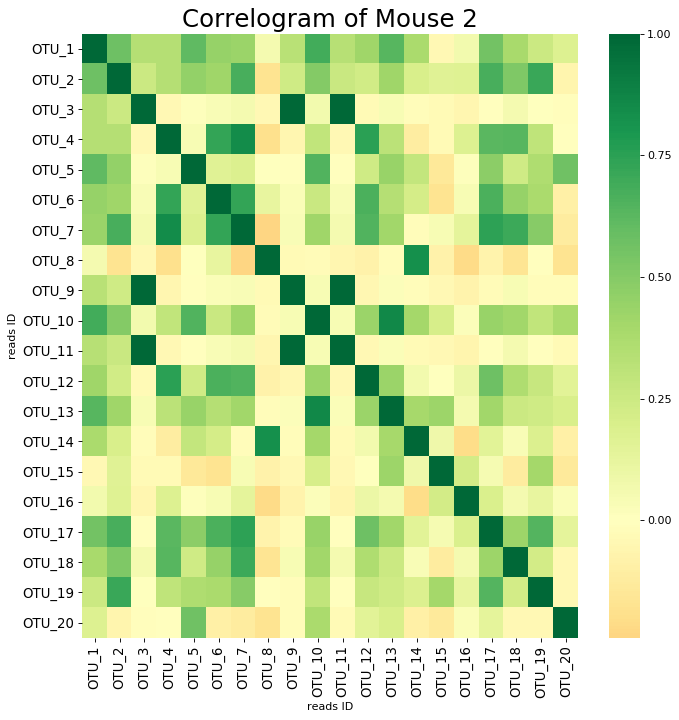

In [538]:
# Plot
fig = plt.figure(figsize=(10,10), dpi= 80)
sns.heatmap(corr_matrix,cmap='RdYlGn', center=0)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel('reads ID')
plt.ylabel('reads ID')

# Decorations
plt.title('Correlogram of Mouse 2', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


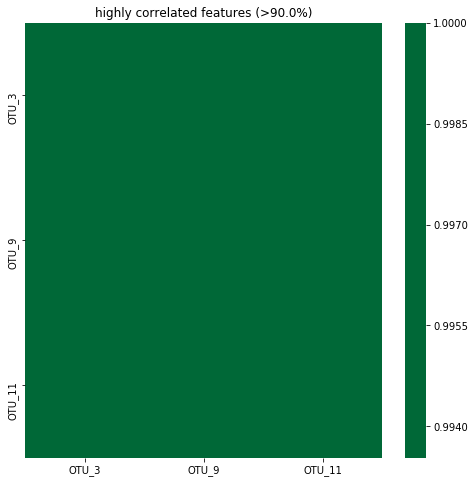

number of correlated features :  3


In [539]:
threshold=0.90
mask = corr_matrix[np.abs(corr_matrix)>threshold].sum()>1

if (mask==True).sum()>1:
    fig = plt.figure(figsize=(8,8))
    ax=fig.add_subplot(111)
    sns.heatmap(corr_matrix.loc[mask, mask],cmap='RdYlGn', center=0)
    plt.title('highly correlated features (>{}%)'.format(threshold*100))
    plt.show()

    print('number of correlated features : ', mask[mask==True].shape[0])
else:
    print('no correlated features')

## PCA

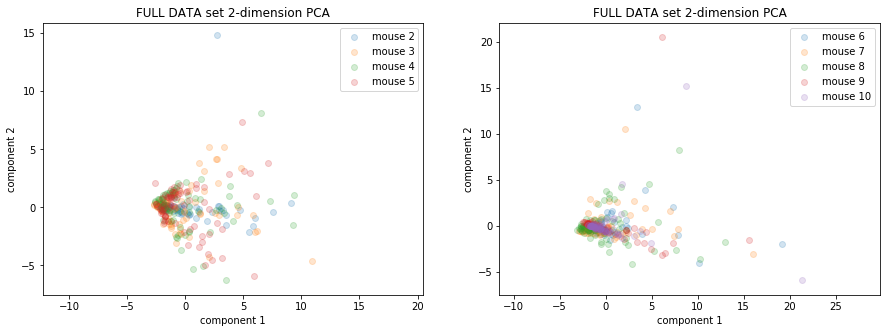

In [543]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(121)
for i in [2,3,4,5]:
    test = mice[i]
    tmp_df = pd.DataFrame(test['reads_standardized'][:20,:].transpose())
    tmp_df.columns = test['otus'][:20]
    
    pca = PCA(n_components=2)
    X=pca.fit_transform(tmp_df.values)
    # plot data
    plt.scatter(X[:, 0], X[:, 1], alpha=0.2, label='mouse {}'.format(i))
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.title('FULL DATA set 2-dimension PCA')
    plt.axis('equal');    
plt.legend()


ax2 = fig.add_subplot(122)
for i in [6,7,8,9,10]:
    test = mice[i]
    tmp_df = pd.DataFrame(test['reads_standardized'][:20,:].transpose())
    tmp_df.columns = test['otus'][:20]
    
    pca = PCA(n_components=2)
    X=pca.fit_transform(tmp_df.values)
    # plot data
    plt.scatter(X[:, 0], X[:, 1], alpha=0.2, label='mouse {}'.format(i))
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.title('FULL DATA set 2-dimension PCA')
    plt.axis('equal');
plt.legend()

# Preprocessing the series

In [592]:
t = 0.05
new_df = pd.DataFrame(winsorize(df, limits=[0,t], axis=0))
x = new_df.values #returns a numpy array
min_max_scaler = preprocessing.StandardScaler()
x_scaled = min_max_scaler.fit_transform(x)
new_df = pd.DataFrame(x_scaled)
new_df = new_df.clip(-3,3)
new_df /=3

new_df.columns =  test['otus'][:20]

In [593]:
new_df.describe()

,OTU_1,OTU_2,OTU_3,OTU_4,OTU_5,OTU_6,OTU_7,OTU_8,OTU_9,OTU_10,OTU_11,OTU_12,OTU_13,OTU_14,OTU_15,OTU_16,OTU_17,OTU_18,OTU_19,OTU_20
count,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01
mean,-3.497963e-17,-1.750883e-16,-1.007565e-16,-6.492143e-16,2.478991e-16,3.041707e-17,2.889622e-17,3.041707e-17,4.866731e-17,1.444811e-17,-1.977109e-17,6.995926e-17,-2.477090e-16,-2.129195e-17,-3.231814e-16,4.440892e-16,-1.921979e-16,-9.790494e-18,1.003763e-16,-2.129195e-17
std,1.006920e+00,1.006920e+00,1.006920e+00,1.006920e+00,1.006920e+00,1.006920e+00,1.006920e+00,1.006920e+00,1.006920e+00,1.006920e+00,1.006920e+00,1.006920e+00,1.006920e+00,1.006920e+00,1.006920e+00,1.006920e+00,1.006920e+00,1.006920e+00,1.006920e+00,1.006920e+00
min,-1.070561e+00,-1.311354e+00,-9.337108e-01,-6.863901e-01,-6.435166e-01,-9.381461e-01,-1.104089e+00,-8.028114e-01,-9.345920e-01,-9.042299e-01,-8.681174e-01,-6.010397e-01,-9.602045e-01,-5.845933e-01,-5.709106e-01,-4.712655e-01,-4.023706e-01,-7.450144e-01,-4.511533e-01,-5.545564e-01
25%,-7.380427e-01,-7.529971e-01,-7.081771e-01,-6.654259e-01,-6.119750e-01,-7.915156e-01,-7.633638e-01,-7.013612e-01,-8.569148e-01,-6.459388e-01,-6.930832e-01,-6.010397e-01,-7.071174e-01,-5.845933e-01,-5.709106e-01,-4.712655e-01,-4.023706e-01,-7.135071e-01,-4.511533e-01,-5.407497e-01
50%,-4.055209e-01,-3.759984e-01,-3.199305e-01,-4.150012e-01,-5.128656e-01,-3.739940e-01,-3.355181e-01,-4.051375e-01,-2.538594e-01,-3.514293e-01,-4.785728e-01,-3.859484e-01,-3.526748e-01,-4.860651e-01,-4.581727e-01,-4.520177e-01,-3.402073e-01,-4.484231e-01,-4.048873e-01,-4.367993e-01
75%,6.054100e-01,6.240024e-01,3.914138e-01,1.118937e-01,1.176206e-01,5.011492e-01,6.781926e-01,2.014378e-01,4.160145e-01,1.798134e-01,5.578002e-01,2.001143e-02,3.429733e-01,6.891873e-02,7.623092e-04,-1.077733e-01,-1.989885e-01,1.317906e-01,-1.840277e-01,7.032774e-02
max,2.648194e+00,2.187725e+00,2.775260e+00,3.223763e+00,3.069213e+00,2.526337e+00,2.287383e+00,3.000280e+00,2.629830e+00,2.777541e+00,2.797909e+00,3.470493e+00,2.647231e+00,3.414934e+00,2.909293e+00,3.556360e+00,3.948625e+00,2.689437e+00,3.478400e+00,3.302769e+00


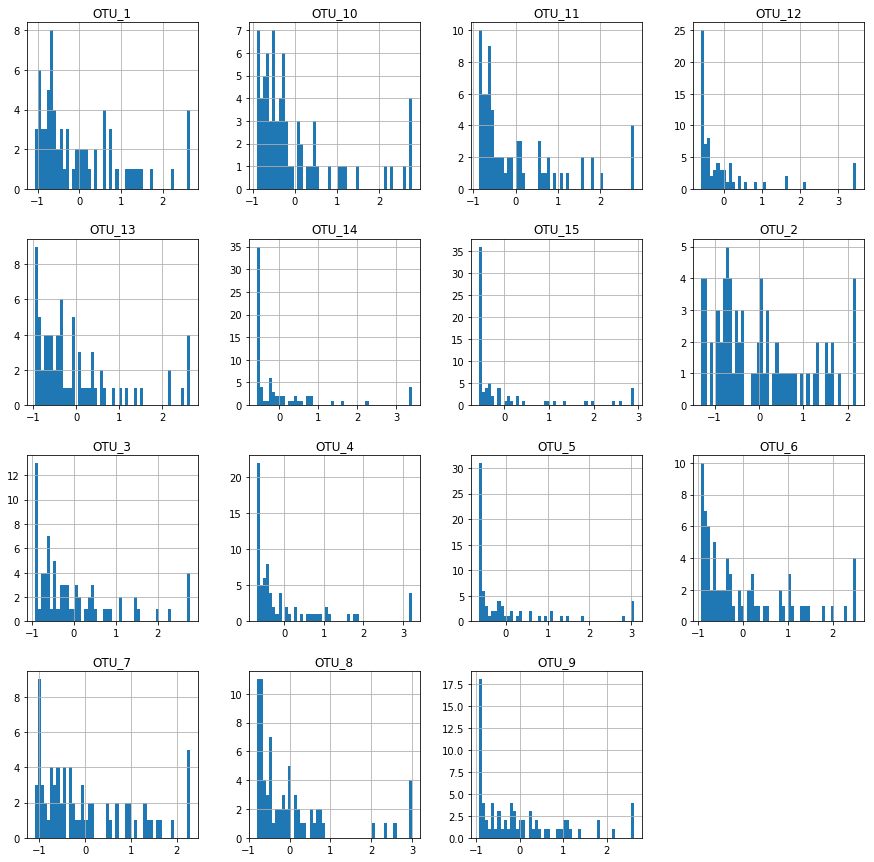

In [594]:
new_df.iloc[:,:15].hist(bins=50, figsize=(15,15))
plt.show()

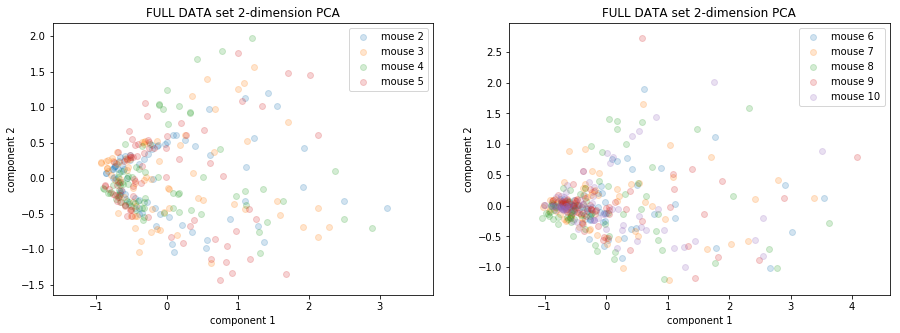

In [715]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(121)
for i in [2,3,4,5]:
    test = mice[i]
    df = pd.DataFrame(test['reads_standardized'][:20,:].transpose())
    df.columns = test['otus'][:20]
    df = pd.DataFrame(winsorize(df, limits=[0.02,0.02], axis=0))
    x = df.values
    min_max_scaler = preprocessing.StandardScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)
    df = df.clip(-3,3)
    df /=3
    
    
    
    pca = PCA(n_components=2)
    X=pca.fit_transform(df.values)
    # plot data
    plt.scatter(X[:, 0], X[:, 1], alpha=0.2, label='mouse {}'.format(i))
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.title('FULL DATA set 2-dimension PCA')
    plt.axis('equal');    
plt.legend()


ax2 = fig.add_subplot(122)
for i in [6,7,8,9,10]:
    test = mice[i]
    df = pd.DataFrame(test['reads_standardized'][:20,:].transpose())
    df.columns = test['otus'][:20]
    df = pd.DataFrame(winsorize(df, limits=[0.02,0.02], axis=0))
    x = df.values
    min_max_scaler = preprocessing.StandardScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)
    df = df.clip(-3,3)
    df /=3
    
    
    pca = PCA(n_components=2)
    X=pca.fit_transform(df.values)
    # plot data
    plt.scatter(X[:, 0], X[:, 1], alpha=0.2, label='mouse {}'.format(i))
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.title('FULL DATA set 2-dimension PCA')
    plt.axis('equal');
plt.legend()

# ADF


In [596]:
results = new_df.apply(adfuller)

In [597]:
adf_results = list(results.apply(lambda x:x[0]))
pval_results = list(results.apply(lambda x:x[1]))
critic = list(results.apply(lambda x:x[4]['5%']))
indexes = [i for i in range(len(critic))]

In [598]:
pval_results, adf_results, critic, indexes = zip(*sorted(zip(pval_results, adf_results, critic, indexes)))

In [599]:
pval_results=np.array(pval_results)
adf_results=np.array(adf_results)



good_indexes = pval_results<0.05
good_pval = pval_results[good_indexes]

bad_indexes = pval_results>=0.05
bad_pval= pval_results[bad_indexes]

good_adf = adf_results[good_indexes]
bad_adf = adf_results[bad_indexes]

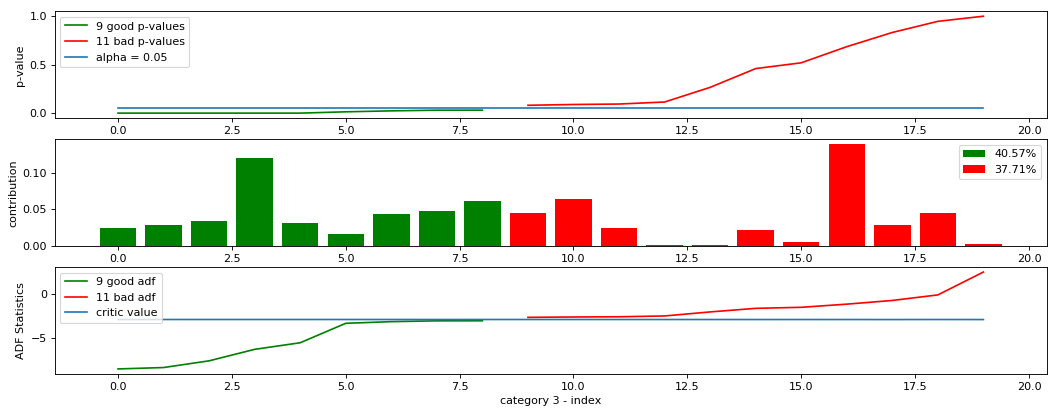

In [600]:
# Draw Plot
fig = plt.figure(figsize=(16,6), dpi=80)

ax1 = fig.add_subplot(311)
plt.plot(good_pval, color='g', label = '{} good p-values'.format(good_pval.shape[0]))
plt.plot(range(good_pval.shape[0],len(pval_results)),bad_pval, color='r', label = '{} bad p-values'.format(bad_pval.shape[0]))
plt.plot(range(len(pval_results)),[0.05]*len(pval_results), label='alpha = 0.05')
plt.ylabel('p-value')
plt.legend()


ax2 = fig.add_subplot(312, sharex=ax1)
n_good = good_indexes.astype(int).sum()
tot_good = data[2]['contribution'][list(indexes)][good_indexes].sum()
plt.bar(range(n_good),data[2]['contribution'][list(indexes)][good_indexes], color='green', label='{}%'.format(round(tot_good*100,2)))

n_bad= bad_indexes.astype(int).sum()
tot_bad = data[2]['contribution'][list(indexes)][bad_indexes].sum()
plt.bar(range(n_good, n_good+n_bad),data[2]['contribution'][list(indexes)][bad_indexes], color='red', label='{}%'.format(round(tot_bad*100,2)))

plt.ylabel('contribution')
plt.legend()

ax3 = fig.add_subplot(313, sharex=ax1)
plt.plot(good_adf, color='g', label = '{} good adf'.format(good_adf.shape[0]))
plt.plot(range(good_adf.shape[0],len(adf_results)),bad_adf, color='r', label = '{} bad adf'.format(bad_adf.shape[0]))
plt.plot(critic, label='critic value')

plt.ylabel('ADF Statistics')
plt.xlabel('category 3 - index')

plt.legend()
plt.show()

## Correlation

In [601]:
# Plot
plt.figure(figsize=(12,12), dpi= 80)
corr_matrix = new_df.corr()

<Figure size 960x960 with 0 Axes>

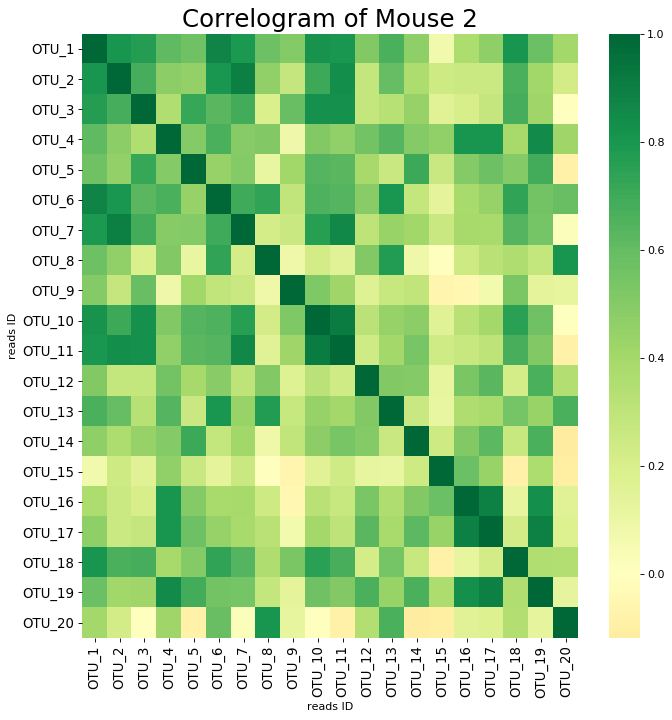

In [602]:
# Plot
fig = plt.figure(figsize=(10,10), dpi= 80)
sns.heatmap(corr_matrix,cmap='RdYlGn', center=0)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel('reads ID')
plt.ylabel('reads ID')

# Decorations
plt.title('Correlogram of Mouse 2', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


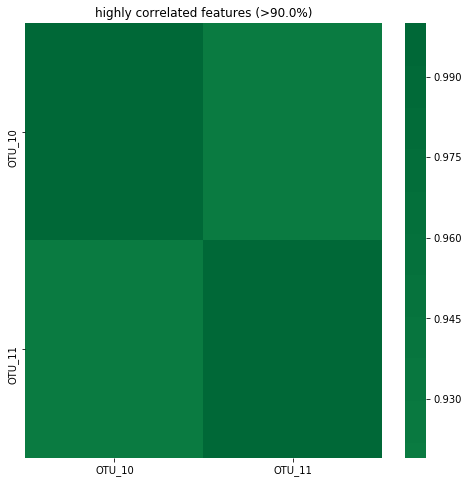

number of correlated features :  2


In [603]:
threshold=0.90
mask = corr_matrix[np.abs(corr_matrix)>threshold].sum()>1

if (mask==True).sum()>1:
    fig = plt.figure(figsize=(8,8))
    ax=fig.add_subplot(111)
    sns.heatmap(corr_matrix.loc[mask, mask],cmap='RdYlGn', center=0)
    plt.title('highly correlated features (>{}%)'.format(threshold*100))
    plt.show()

    print('number of correlated features : ', mask[mask==True].shape[0])
else:
    print('no correlated features')

# Autoencoder

## gather all the data

In [571]:
full_df = None

In [572]:
for i in range(2,11):
    test = mice[i]
    df = pd.DataFrame(test['reads_standardized'][:20,:].transpose())
    df.columns = test['otus'][:20]
    if full_df is None:
        full_df = df
    else:
        full_df = pd.concat([full_df, df], axis=0)

In [573]:
full_df.shape

(665, 20)

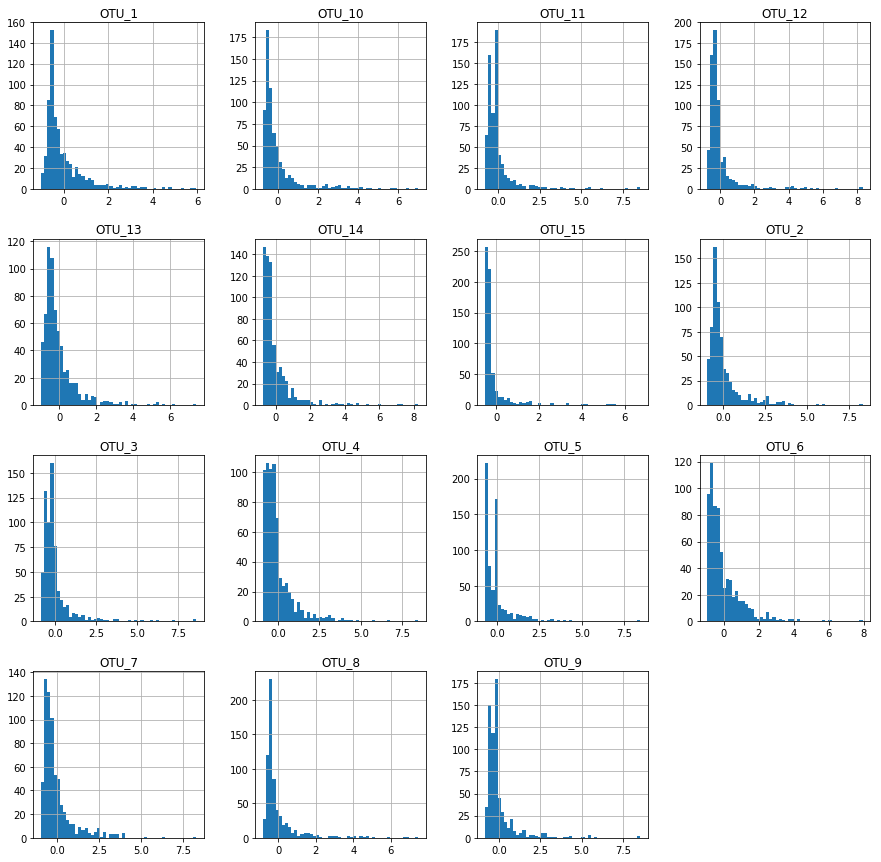

In [574]:
full_df.iloc[:,:15].hist(bins=50, figsize=(15,15))
plt.show()

In [673]:
t = 0.05
full_df = pd.DataFrame(winsorize(full_df, limits=[0,t], axis=0))
x = full_df.values #returns a numpy array
min_max_scaler = preprocessing.StandardScaler()
x_scaled = min_max_scaler.fit_transform(x)
full_df = pd.DataFrame(x_scaled)
full_df = full_df.clip(-3,3)
full_df /=3

full_df.columns =  test['otus'][:20]

In [674]:
full_df.describe()

,OTU_1,OTU_2,OTU_3,OTU_4,OTU_5,OTU_6,OTU_7,OTU_8,OTU_9,OTU_10,OTU_11,OTU_12,OTU_13,OTU_14,OTU_15,OTU_16,OTU_17,OTU_18,OTU_19,OTU_20
count,6.650000e+02,6.650000e+02,6.650000e+02,6.650000e+02,6.650000e+02,6.650000e+02,6.650000e+02,6.650000e+02,665.000000,665.000000,6.650000e+02,665.000000,6.650000e+02,6.650000e+02,665.000000,6.650000e+02,6.650000e+02,6.650000e+02,665.000000,665.000000
mean,-3.339017e-19,-4.606799e-18,-8.138853e-18,1.039791e-17,2.399918e-18,6.010230e-18,8.076246e-18,1.085180e-17,-0.000515,-0.003974,2.838164e-18,-0.001778,4.971678e-18,4.507672e-18,-0.004809,-8.243197e-18,2.608607e-18,8.138853e-18,-0.002877,-0.000247
std,3.335842e-01,3.335842e-01,3.335842e-01,3.335842e-01,3.335842e-01,3.335842e-01,3.335842e-01,3.335842e-01,0.332026,0.320939,3.335842e-01,0.328103,3.335842e-01,3.335842e-01,0.318093,3.335842e-01,3.335842e-01,3.335842e-01,0.324583,0.332839
min,-3.599194e-01,-3.303548e-01,-3.732075e-01,-3.709796e-01,-2.908051e-01,-3.428545e-01,-3.248194e-01,-3.101714e-01,-0.401680,-0.279992,-3.734267e-01,-0.348997,-3.793276e-01,-3.380726e-01,-0.235571,-3.910097e-01,-4.385854e-01,-3.006403e-01,-0.341695,-0.276211
25%,-2.210722e-01,-2.106809e-01,-2.312606e-01,-2.299764e-01,-2.403935e-01,-2.555473e-01,-2.195347e-01,-1.908771e-01,-0.221176,-0.199167,-2.259959e-01,-0.210981,-2.269866e-01,-2.155025e-01,-0.166669,-2.522970e-01,-1.957935e-01,-1.931193e-01,-0.205914,-0.186435
50%,-1.315218e-01,-1.172431e-01,-4.419910e-02,-9.545765e-02,-6.642321e-02,-1.213093e-01,-1.144225e-01,-1.246131e-01,-0.054910,-0.128726,-4.283619e-02,-0.080045,-1.159175e-01,-1.261186e-01,-0.115505,-7.926098e-02,-7.299845e-02,-1.523070e-01,-0.084825,-0.142042
75%,1.198999e-01,8.182434e-02,4.565255e-02,9.708601e-02,5.959068e-07,1.725928e-01,7.618639e-02,5.291981e-02,0.028886,0.041034,4.465361e-02,0.036042,1.170388e-01,1.326790e-01,-0.046778,6.137481e-02,4.928166e-02,3.807072e-02,0.003641,0.017673
max,9.109261e-01,9.643709e-01,9.577244e-01,9.085264e-01,9.584758e-01,8.279484e-01,9.792901e-01,9.843777e-01,1.000000,1.000000,9.798355e-01,1.000000,8.998614e-01,9.294823e-01,1.000000,9.379438e-01,9.393234e-01,9.208281e-01,1.000000,1.000000


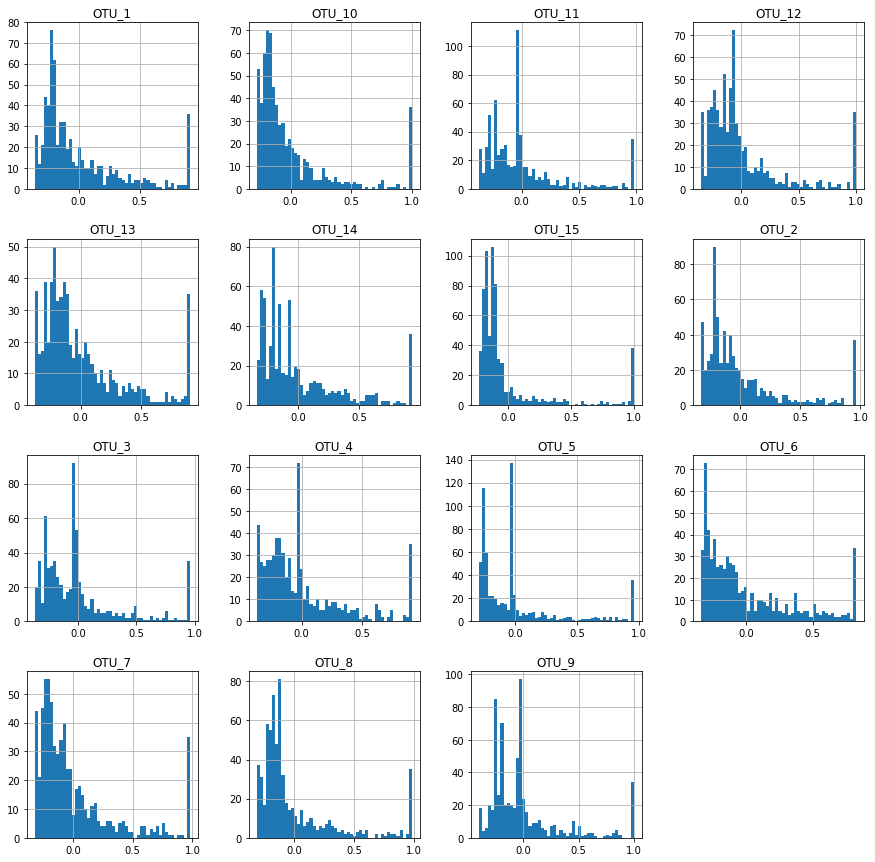

In [675]:
full_df.iloc[:,:15].hist(bins=50, figsize=(15,15))
plt.show()

## PCA

In [676]:
train_frac = 0.80
max_train_index = int( train_frac * full_df.shape[0])
train_df = full_df.iloc[:max_train_index]
test_df = full_df.iloc[max_train_index:]

#train_df, test_df = train_test_split(new_df, test_size=0.2)

In [677]:
print('train set of shape ', train_df.shape)
print('test set of shape ', test_df.shape)

train set of shape  (532, 20)
test set of shape  (133, 20)


In [678]:
def compute_error_PCA(train_data, test_data, dims_list):
    error_list_test = []
    error_list_train = []
    R2_list_test = []
    R2_list_train = []


    for dim in tqdm(dims_list):
        #fit model on train data
        local_covar = PCA(dim)
        pred = local_covar.fit_transform(train_data)
        
        reconstruction = local_covar.inverse_transform(pred)
        error = sklearn.metrics.mean_squared_error(train_data,reconstruction)
        error_list_train+=[error]
        R2_list_train+=[sklearn.metrics.r2_score(train_data, reconstruction)]
        
        
        #evaluate on test data
        X = test_data
        pred = local_covar.transform(X)
        reconstruction = local_covar.inverse_transform(pred)
        error = sklearn.metrics.mean_squared_error(X,reconstruction)
        error_list_test+=[error]
        R2_list_test+=[sklearn.metrics.r2_score(X, reconstruction)]
    return(error_list_train, error_list_test, R2_list_train, R2_list_test)

In [679]:
train_data = train_df.values
test_data = test_df.values

In [680]:
#compute % of variance explained

covar_matrix = PCA()
covar_matrix.fit(train_data)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
var=np.cumsum(covar_matrix.explained_variance_ratio_*100)

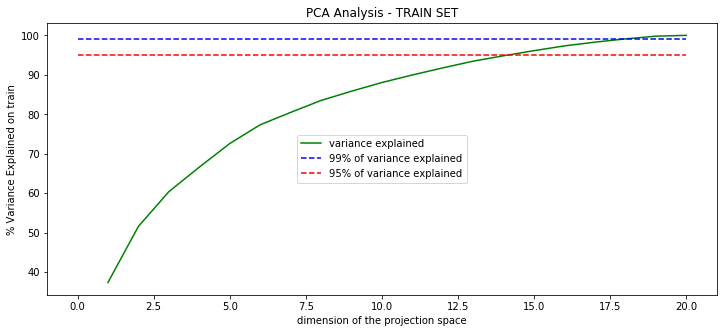

In [681]:
fig= plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(111)
plt.plot(range(1,1+len(var)),var, label='variance explained', color='g')
plt.plot([0,len(var)],[99,99], 'r--', label='99% of variance explained', color='b')
plt.plot([0,len(var)],[95,95], 'r--', label='95% of variance explained', color='r')


plt.xlabel('dimension of the projection space')
plt.ylabel('% Variance Explained on train')
plt.title('PCA Analysis - TRAIN SET')
plt.legend(loc=10)


plt.show()

In [682]:
dims_list = np.linspace(1,train_data.shape[-1],10, dtype=int)
error_train, error_test, R2_train, R2_test = compute_error_PCA(train_data, test_data, dims_list)

100%|██████████| 10/10 [00:00<00:00, 268.98it/s]


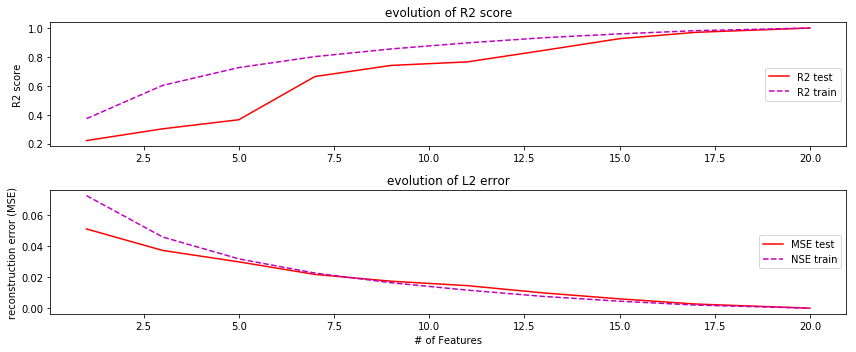

In [683]:
fig= plt.figure(figsize=(12,5))
ax = fig.add_subplot(211)
plt.plot(dims_list,np.array(R2_test), label='R2 test', color='r')
plt.plot(dims_list,np.array(R2_train), 'r--',label='R2 train', color='m')
plt.ylabel('R2 score')
plt.title('evolution of R2 score')
plt.legend(loc=5)


ax3 = fig.add_subplot(212, sharex=ax)
plt.plot(dims_list,error_test, label='MSE test', color='r')
plt.plot(dims_list,error_train, 'r--',label='NSE train', color='m')
plt.ylabel('reconstruction error (MSE)')
plt.xlabel('# of Features')
plt.title('evolution of L2 error')
plt.legend(loc=5)


fig.tight_layout()
plt.show()



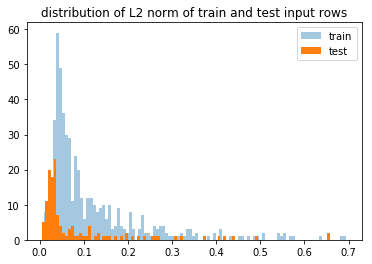

In [684]:
plt.hist((train_data**2).mean(axis=1).reshape(-1), label='train', alpha=0.4, bins=100)
plt.hist((test_data**2).mean(axis=1).reshape(-1), label='test', bins=100)
plt.legend()
plt.title('distribution of L2 norm of train and test input rows')
plt.show()

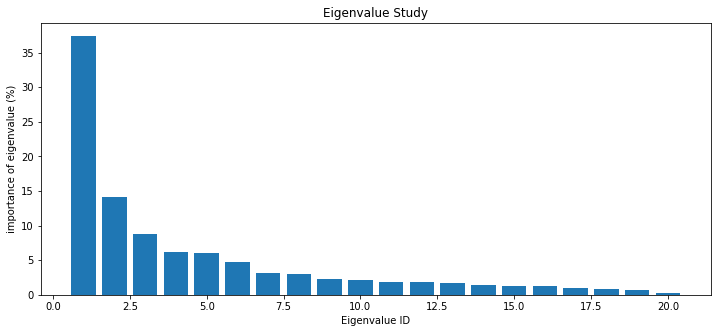

In [685]:
fig= plt.figure(figsize=(12,5))


plt.bar(range(1,1+len(var)),covar_matrix.explained_variance_ratio_*100)
plt.ylabel('importance of eigenvalue (%)')
plt.xlabel('Eigenvalue ID')
plt.title('Eigenvalue Study')
plt.show()

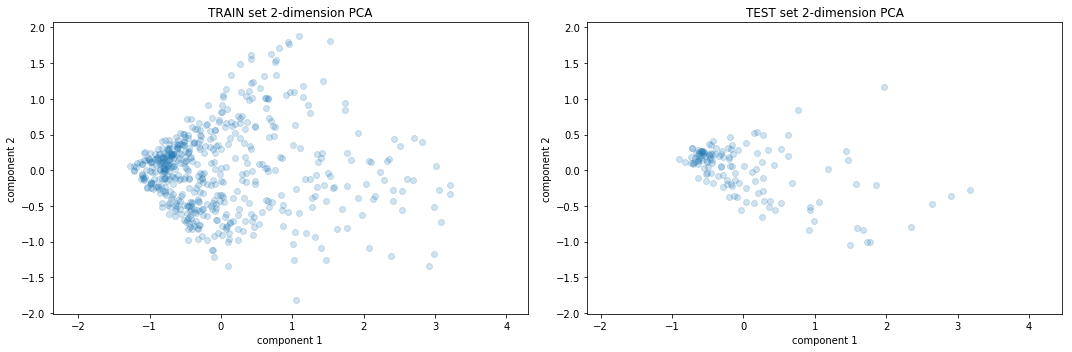

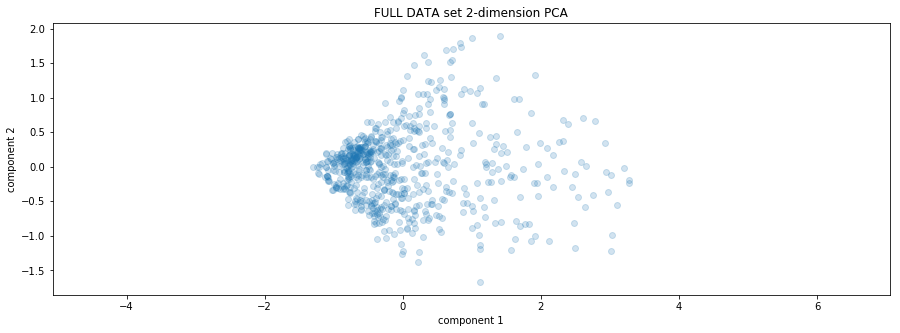

In [686]:
pca = PCA(n_components=2)
X=pca.fit_transform(train_data)
fig = plt.figure(figsize=(15,5))
ax=fig.add_subplot(121)
# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('TRAIN set 2-dimension PCA')
plt.axis('equal');


X=pca.transform(test_data)
ax2=fig.add_subplot(122, sharey=ax)
# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('TEST set 2-dimension PCA')
plt.axis('equal');
plt.tight_layout()
plt.show()

pca = PCA(n_components=2)
X=pca.fit_transform(full_df.values)
fig = plt.figure(figsize=(15,5))
# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('FULL DATA set 2-dimension PCA')
plt.axis('equal');

## Error analysis

In [687]:
new_df=new_df.reset_index(drop=True)
train_df=train_df.reset_index(drop=True)
test_df=test_df.reset_index(drop=True)

C:\Users\simon\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


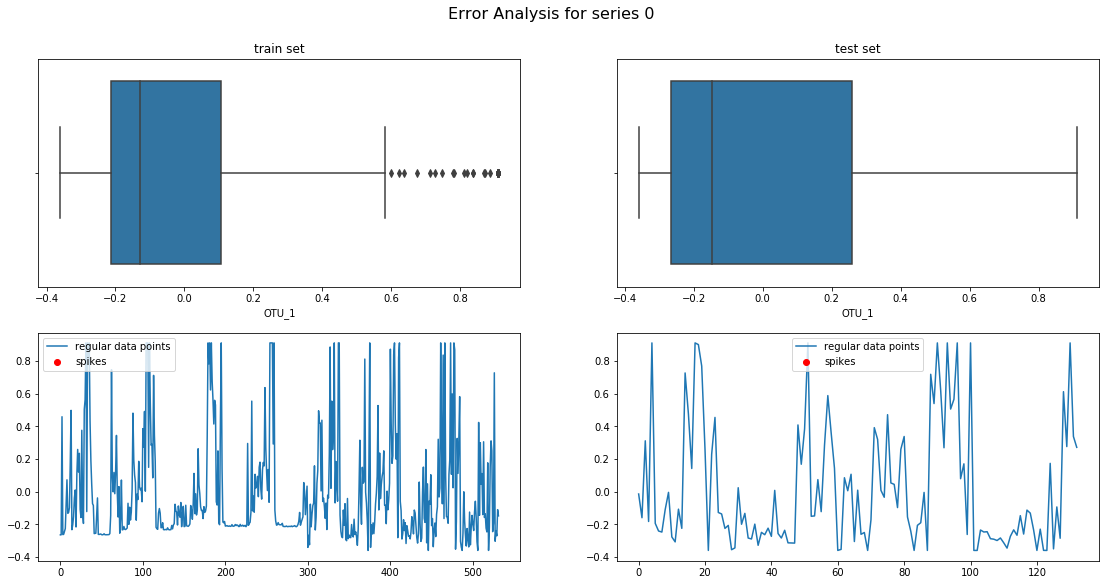

In [688]:
index = 0

fig = plt.figure(figsize=(19,9))

series = train_df.iloc[:,index]
pca = PCA(n_components=2)
X=pca.fit_transform(train_data)


ax1 = fig.add_subplot(221)
sns.boxplot(series)
plt.title('train set')

ax2 = fig.add_subplot(223)
#compute location of spikes
indexes = np.argwhere(np.abs(series)>2).reshape(-1)
values = series[(np.abs(series)>2)]
#plot them
plt.plot(series, label='regular data points')
plt.scatter(indexes, values, color='r', label='spikes')
plt.legend()


series = test_df.iloc[:,index]
ax3 = fig.add_subplot(222)
sns.boxplot(series)
plt.title('test set')

ax4 = fig.add_subplot(224, sharey=ax2)
#compute location of spikes
indexes = np.argwhere(np.abs(series)>2).reshape(-1)
values = series[(np.abs(series)>2)]
#plot them
plt.plot(series, label='regular data points')
plt.scatter(indexes, values, color='r', label='spikes')
plt.legend()

plt.suptitle('Error Analysis for series {}'.format(index), fontsize=16)
plt.subplots_adjust(top=0.9)

In [689]:
min_number_of_dims_99 = np.argmax(var>99)+1
min_number_of_dims_90 = np.argmax(var>90)+1
min_number_of_dims_50 = np.argmax(var>50)+1


_,[error99,error90, error50],_,_ = compute_error_PCA(train_data, test_data, [min_number_of_dims_99, min_number_of_dims_90, min_number_of_dims_50])


print('original number of dimensions : ',  new_df.shape[-1])
print('min_number_of_dims_99% : ', min_number_of_dims_99, ' reconstruction error : ', error99)
print('min_number_of_dims_90% : ', min_number_of_dims_90, ' reconstruction error : ', error90)
print('min_number_of_dims_50% : ', min_number_of_dims_50, ' reconstruction error : ', error50)

100%|██████████| 3/3 [00:00<00:00, 246.64it/s]


original number of dimensions :  20
min_number_of_dims_99% :  18  reconstruction error :  0.0012283359365308584
min_number_of_dims_90% :  12  reconstruction error :  0.012385793932424347
min_number_of_dims_50% :  2  reconstruction error :  0.0444001914630921


C:\Users\simon\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)
C:\Users\simon\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


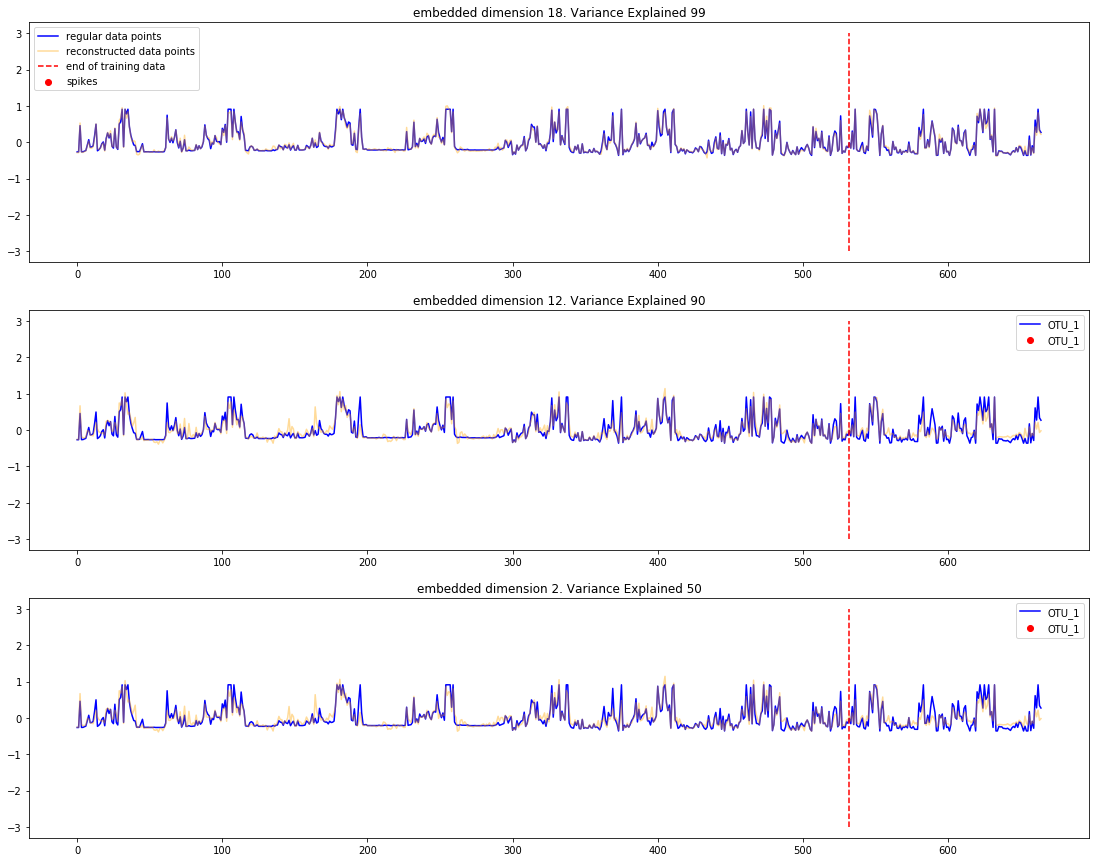

In [690]:
index = 0

fig = plt.figure(figsize=(19,15))

series = full_df.iloc[:,index]

pca = PCA(n_components= min_number_of_dims_99)
pca.fit(train_data)
X=pca.transform(full_df.values)
reconstruction = pca.inverse_transform(X)
rec_series = reconstruction[:,index]


ax1 = fig.add_subplot(311)
#compute location of spikes
indexes = np.argwhere(np.abs(series)>2).reshape(-1)
values = series[(np.abs(series)>2)]
#plot them
plt.plot(series, label='regular data points', color = 'b')
plt.scatter(indexes, values, color='r', label='spikes')
#plot them
plt.plot(rec_series, label='reconstructed data points', color= 'orange', alpha=0.4)
plt.plot([max_train_index,max_train_index],[-3,3], 'r--', color='r', label='end of training data')
plt.legend(loc=2)
plt.title('embedded dimension {}. Variance Explained {}'.format(min_number_of_dims_99, 99))


pca = PCA(n_components= min_number_of_dims_90)
pca.fit(train_data)
X=pca.transform(full_df.values)
reconstruction = pca.inverse_transform(X)
rec_series = reconstruction[:,index]


ax2 = fig.add_subplot(312)
#compute location of spikes
indexes = np.argwhere(np.abs(series)>2).reshape(-1)
values = series[(np.abs(series)>2)]
#plot them
plt.plot(series, color = 'b')
plt.scatter(indexes, values, color='r')
#plot them
plt.plot(rec_series, color= 'orange', alpha=0.4)
plt.plot([max_train_index,max_train_index],[-3,3], 'r--', color='r')
plt.title('embedded dimension {}. Variance Explained {}'.format(min_number_of_dims_90, 90))

plt.legend()

ax3 = fig.add_subplot(313)
#compute location of spikes
indexes = np.argwhere(np.abs(series)>2).reshape(-1)
values = series[(np.abs(series)>2)]
#plot them
plt.plot(series, color = 'b')
plt.scatter(indexes, values, color='r')
#plot them
plt.plot(rec_series, color= 'orange', alpha=0.4)
plt.plot([max_train_index,max_train_index],[-3,3], 'r--', color='r')
plt.title('embedded dimension {}. Variance Explained {}'.format(min_number_of_dims_50, 50))

plt.legend()
plt.show()



## Error Distribution

In [691]:
def moving_average (values, window):
        weights = np.repeat(1.0, window)/window
        sma = np.convolve(values, weights, 'valid')
        return sma

def compute_error_distr_pca(original, reconstruction):
           
    l2_error = np.power(reconstruction-original,2)
    list_error = l2_error.reshape(-1)
    list_z = original.reshape(-1)

    inds = list_z.argsort()
    list_error = list_error[inds]
    list_z = list_z[inds]

    
    window=100
    smooth_z = moving_average(list_z, window)
    smooth_error = moving_average(list_error, window)
    print('smoothed')
    return(smooth_z, smooth_error)

def compute_error_distr_pca_norm(original, reconstruction):
           
    l2_error = np.power(reconstruction-original,2)
    list_error = np.mean(l2_error, axis=1)
    list_z = np.sum(np.abs(original), axis = 1)

    inds = list_z.argsort()
    list_error = list_error[inds]
    list_z = list_z[inds]

    
    window=100
    smooth_z = moving_average(list_z, window)
    smooth_error = moving_average(list_error, window)
    print('smoothed')
    return(smooth_z, smooth_error)

def compute_error_distr_pca_spike(original, reconstruction):
           
    l2_error = np.power(reconstruction-original,2)
    list_error = np.mean(l2_error, axis=1)
    list_z = 100 * np.mean(np.abs(original)>2/3,axis=1)

    inds = list_z.argsort()
    list_error = list_error[inds]
    list_z = list_z[inds]

    
    window=100
    smooth_z = moving_average(list_z, window)
    smooth_error = moving_average(list_error, window)
    print('smoothed')
    return(smooth_z, smooth_error)

In [692]:
pca_99 = PCA(n_components= min_number_of_dims_99)
pca_99.fit(train_df.values)
original_train = train_df.values
original_test = test_df.values

X_tr=pca_99.transform(train_df.values)
X_te=pca_99.transform(test_df.values)
reconstruction_train_99 = pca_99.inverse_transform(X_tr)
reconstruction_test_99 = pca_99.inverse_transform(X_te)



pca_90 = PCA(n_components= min_number_of_dims_90)
pca_90.fit(train_df.values)
original_train = train_df.values
original_test = test_df.values

X_tr=pca_90.transform(train_df.values)
X_te=pca_90.transform(test_df.values)
reconstruction_train_90 = pca_90.inverse_transform(X_tr)
reconstruction_test_90 = pca_90.inverse_transform(X_te)



pca_50 = PCA(n_components= min_number_of_dims_50)
pca_50.fit(train_df.values)
original_train = train_df.values
original_test = test_df.values

X_tr=pca_50.transform(train_df.values)
X_te=pca_50.transform(test_df.values)
reconstruction_train_50 = pca_50.inverse_transform(X_tr)
reconstruction_test_50 = pca_50.inverse_transform(X_te)

In [693]:
tr_list_z_99, tr_list_error_99 = compute_error_distr_pca(original_train, reconstruction_train_99)
te_list_z_99, te_list_error_99 = compute_error_distr_pca(original_test, reconstruction_test_99)

tr_list_z_90, tr_list_error_90 = compute_error_distr_pca(original_train, reconstruction_train_90)
te_list_z_90, te_list_error_90 = compute_error_distr_pca(original_test, reconstruction_test_90)

tr_list_z_50, tr_list_error_50 = compute_error_distr_pca(original_train, reconstruction_train_50)
te_list_z_50, te_list_error_50 = compute_error_distr_pca(original_test, reconstruction_test_50)

smoothed
smoothed
smoothed
smoothed
smoothed
smoothed


C:\Users\simon\Anaconda3\lib\site-packages\matplotlib\gridspec.py:335: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


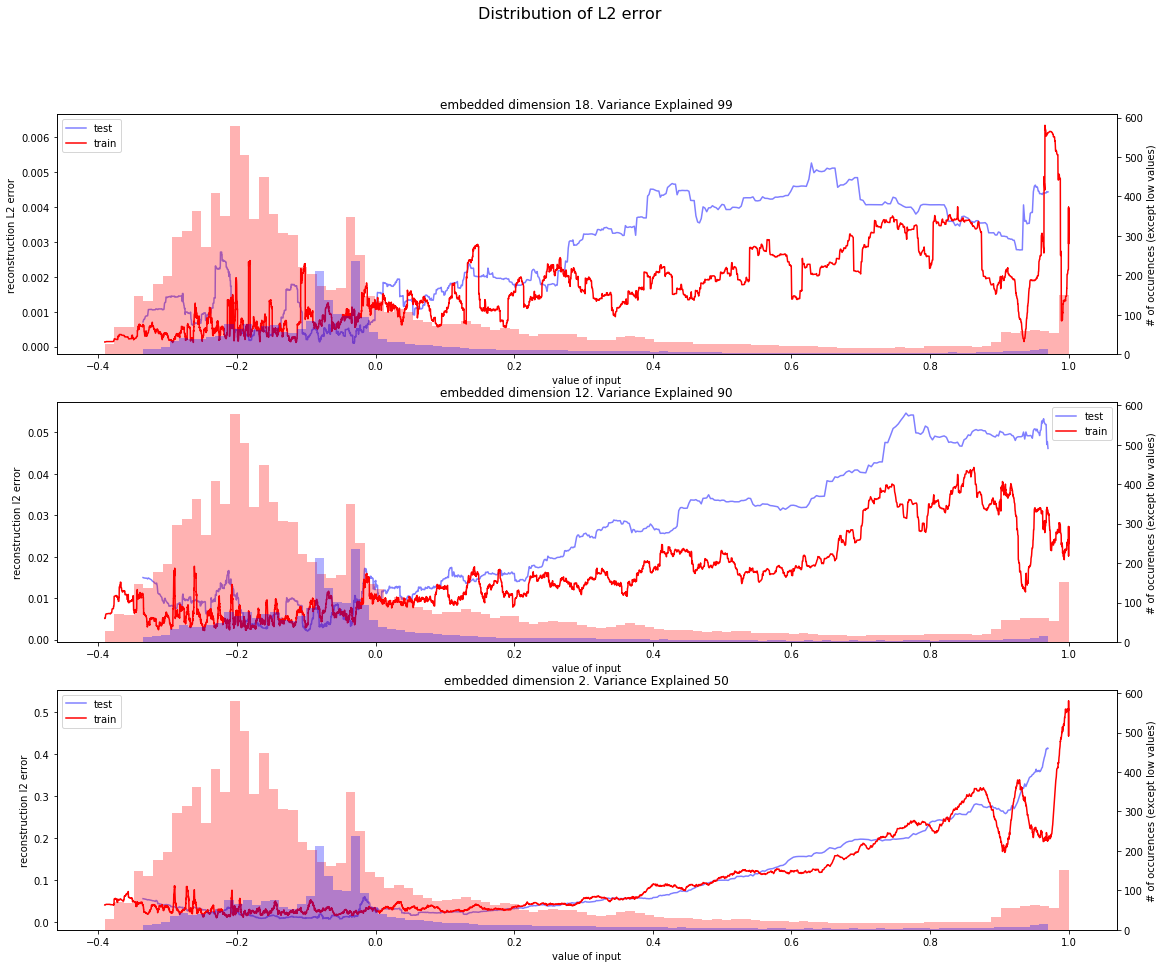

In [694]:
fig = plt.figure(figsize=(19,15))
gs1 = gridspec.GridSpec(3,1)


ax1=fig.add_subplot(311)
plt.plot(te_list_z_99, np.array(te_list_error_99), label='test', color='b', alpha=0.5)
plt.plot(tr_list_z_99,  np.array(tr_list_error_99), label='train', color='r')
plt.title('embedded dimension {}. Variance Explained {}'.format(min_number_of_dims_99, 99))
plt.ylabel('reconstruction L2 error')
plt.xlabel('value of input')
plt.legend()

ax2=ax1.twinx()
plt.hist(tr_list_z_99, bins=100, alpha=0.3, color='r')
plt.hist(te_list_z_99, bins=100, alpha=0.3, color='b')
plt.ylabel('# of occurences (except low values)')


ax3=fig.add_subplot(312)
plt.plot(te_list_z_90, np.array(te_list_error_90), label='test', color='b', alpha=0.5)
plt.plot(tr_list_z_90,  np.array(tr_list_error_90), label='train', color='r')
plt.title('embedded dimension {}. Variance Explained {}'.format(min_number_of_dims_90, 90))
plt.ylabel('reconstruction l2 error')
plt.xlabel('value of input')
plt.legend()

ax4=ax3.twinx()
plt.hist(tr_list_z_90, bins=100, alpha=0.3, color='r')
plt.hist(te_list_z_90, bins=100, alpha=0.3, color='b')
plt.ylabel('# of occurences (except low values)')


ax5=fig.add_subplot(313)
plt.plot(te_list_z_50, np.array(te_list_error_50), label='test', color='b', alpha=0.5)
plt.plot(tr_list_z_50,  np.array(tr_list_error_50), label='train', color='r')
plt.title('embedded dimension {}. Variance Explained {}'.format(min_number_of_dims_50, 50))
plt.xlabel('value of input')
plt.ylabel('reconstruction l2 error')
plt.legend()

ax6=ax5.twinx()
plt.hist(tr_list_z_50, bins=100, alpha=0.3, color='r')
plt.hist(te_list_z_50, bins=100, alpha=0.3, color='b')
plt.ylabel('# of occurences (except low values)')

plt.suptitle('Distribution of L2 error', fontsize=16)

#plt.subplots_adjust(top=0.99)
gs1.tight_layout(fig, rect=[0, 0.02, 1, 0.95])  
plt.show()

# Autoencoder

In [784]:
import torch
from copy import deepcopy
from time import time
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.utils.data as utils
import torch.nn as nn
from torch.autograd import Variable

In [785]:
my_dataset = utils.TensorDataset(torch.Tensor(train_df.values))# create your datset
my_dataloader = utils.DataLoader(my_dataset, 64, shuffle=True) # create your dataloader

In [786]:
test_data = torch.Tensor(test_df.values)

In [787]:
class autoencoder(nn.Module):
    def __init__(self,
                input_dim,
                hidden_dim=None):
        super(autoencoder, self).__init__()
        self.input_dim = input_dim
        
        if hidden_dim:
            self.hidden_dim = hidden_dim
        else:
            self.hidden_dim = int(self.input_dim*0.8)
            
        
        self.enc_01 = nn.Linear(input_dim, input_dim)
        self.enc_1 = nn.Linear(input_dim, self.hidden_dim)
        self.enc_02 = nn.Linear(self.hidden_dim, self.hidden_dim)

     
        self.dec_01 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.dec_1 = nn.Linear(self.hidden_dim, self.input_dim)
        self.dec_02 = nn.Linear(self.input_dim, self.input_dim)        
        

        self.dropout = torch.nn.Dropout(0)
        self.tanh=nn.Tanh()
        self.relu = nn.ReLU()
        self.hardtanh = nn.Hardtanh(min_val=-1, max_val=1)
        
        if torch.cuda.is_available():
            self = self.cuda()
            


    def encoder(self, x):
        h1 = x        
        
        tmp = self.enc_01(h1)
        tmp = self.hardtanh(tmp)
        h1 = h1 + tmp 
                
        h1 = self.enc_1(h1)
        h1 = self.hardtanh(h1) 
                           
        tmp = self.enc_02(h1)
        tmp = self.hardtanh(tmp)
        h1 = h1 + tmp  
        
        h1 = self.hardtanh(h1)
             
        return (h1)
    

    def decoder(self,z):
        b1 = z
        
        tmp = self.dec_01(b1)
        tmp =self.hardtanh(tmp)
        b1 = b1 + tmp
                
        b1 = self.dec_1(b1)
        b1 = self.hardtanh(b1)
              
        tmp = self.dec_02(b1)
        tmp = self.hardtanh(tmp)
        b1 = b1 + tmp
              
        b1 = self.hardtanh(b1)
        
        return (b1)

    
    def forward(self, x):
        code = self.encoder(x)
        reconstruction = self.decoder(code)        
        return (code, reconstruction)

In [788]:
num_epochs = 1000
learning_rate = 1e-4

In [789]:
model = autoencoder(train_df.shape[-1],10)

In [790]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)
#scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=50)
#optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)

In [791]:
def train_model (model, test_data = test_data, num_epochs = num_epochs, use_noise = False,
                 my_dataloader = my_dataloader, noiser = None, criterion = criterion,
                 optimizer = optimizer):
    
    # initiate storages
    train_loss = []
    test_loss = []
    r_score_train = []
    r_score_test = []

    #indexes of the batch where we evaluate the test set
    test_batch_id = []

    # initialize denominator for computation of r_2
    X_test = Variable(test_data)    
    if torch.cuda.is_available():
        X_test = X_test.cuda()
    r_denom_test = ((X_test-X_test.mean())**2).mean()
    r_denom_test = r_denom_test.detach().data.cpu().numpy()
    

    #tqdm print
    i=0
    iter_epoch = tqdm(range(num_epochs))
    
                 
    #initiate random large best scores
    best_loss = 100
    best_model=None
    best_epoch=0
    



    for epoch in iter_epoch:
        model.train()
        for [data] in my_dataloader:
            
            i+=1
            
            # ==============prepare data=====================
            if use_noise:
                noisy_data = noiser.add_noise(data)
                X = Variable(noisy_data)    
            else:
                X = Variable(data)
                
                
            clean_data = None    
            if use_noise:
                if noiser.type == 'rescaler':
                    clean_data = Variable(noisy_data) 
            else:
                clean_data = Variable(data)  

            if torch.cuda.is_available():
                X = X.cuda()
                clean_data = clean_data.cuda()

            # ===================forward=====================
            code, output = model(X)
            tr_loss = criterion(output, clean_data)
            #print('mean code ', code.mean())
            #print('output_code', output.mean())


            # ===================backward====================
            optimizer.zero_grad()
            tr_loss.backward()
            optimizer.step()
            
            #store train lostt
            train_loss+=[tr_loss.item()]   

            # ===================compute R_score for the train set========================
            r_denom_train = ((clean_data-clean_data.mean())**2).mean().item()
            tr_new_score=1-tr_loss.item()/r_denom_train
            r_score_train +=[tr_new_score]

        # ===================eval========================
        model.eval()
        code, output = model(X_test)
        te_loss = criterion(output, X_test).detach()

        test_loss+=[te_loss.item()]     
        #compute r_2
        te_new_score = 1-te_loss.item()/r_denom_test
        r_score_test +=[te_new_score]

        
        #when we use noise in the AE, we update the amplitude of the noise in the training
        if use_noise:
            if te_new_score > 0.6:
                noiser.update_amplitude(epoch)

        #tqdm plot
        test_batch_id +=[i]
        iter_epoch.set_postfix(train_l=tr_loss.item(),
                               test_l = te_loss.item(),
                               train_r = tr_new_score,
                               test_r = te_new_score)

        #update best model
        if te_loss.item()<best_loss:
            best_loss=te_loss.item()
            best_model=deepcopy(model)
            best_epoch= epoch

        #scheduler.step(te_loss.item())
    #return best model
    model=best_model
    model.eval()
    output = {'model':model,
             'train_loss':train_loss,
             'test_loss':test_loss,
             'r_score_train':r_score_train,
             'r_score_test':r_score_test,
             'test_batch_id':test_batch_id,
             'best_test_loss':best_loss,
             'best_test_epoch':best_epoch}
    return(output)

In [792]:
output_dict = train_model(model)

100%|██████████| 1000/1000 [01:39<00:00, 10.45it/s, test_l=0.0162, test_r=0.808, train_l=0.0166, train_r=0.864] 


In [793]:


def compute_error_distr(tensor):
    X_test = Variable(tensor).cuda()      
    if torch.cuda.is_available():
            X_test = X_test.cuda()
    model.eval()
    code, output = model(X_test)
    l2_error = (output.data-X_test)**2
    list_error = l2_error.view(-1).detach().data.cpu().numpy()
    list_z = X_test.view(-1).detach().data.cpu().numpy()
    
    inds = list_z.argsort()
    list_error = list_error[inds]
    list_z = list_z[inds]
    
    
    
    def moving_average (values, window):
        weights = np.repeat(1.0, window)/window
        sma = np.convolve(values, weights, 'valid')
        return sma
    window=200
    smooth_z = moving_average(list_z, window)
    smooth_error = moving_average(list_error, window)
    
    return(smooth_z, smooth_error)



In [794]:
def compute_error_norm(tensor):
    X_test = Variable(tensor).cuda()      
    if torch.cuda.is_available():
            X_test = X_test.cuda()
    model.eval()
    code, output = model(X_test)
    l2_error = (output.data-X_test)**2
    list_error = l2_error.mean(dim=1).detach().data.cpu().numpy()
    list_z = X_test.abs().sum(dim=1).detach().data.cpu().numpy()
    
    inds = list_z.argsort()
    list_error = list_error[inds]
    list_z = list_z[inds]
    
    
    
    def moving_average (values, window):
        weights = np.repeat(1.0, window)/window
        sma = np.convolve(values, weights, 'valid')
        return sma
    window=20
    smooth_z = moving_average(list_z, window)
    smooth_error = moving_average(list_error, window)
    
    return(smooth_z, smooth_error)

In [795]:
def show_results(output_dict, test_data = test_data, train_df = train_df):
    #update local variables
    model = output_dict['model']
    train_loss = output_dict['train_loss']
    test_loss = output_dict['test_loss']
    r_score_train = output_dict['r_score_train']
    r_score_test = output_dict['r_score_test']
    test_batch_id = output_dict['test_batch_id']
    best_test_loss = output_dict['best_test_loss']
    best_test_epoch = output_dict['best_test_epoch']
                            
        
    
    
    
    
    # Show Loss
    fig=plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(121)
    plt.plot(train_loss, label='train')
    plt.plot(test_batch_id, test_loss, label='test')
    plt.title('loss')
    plt.legend()

    ax1 = fig.add_subplot(122)
    plt.plot(r_score_train, label='train')
    plt.plot(test_batch_id,r_score_test, label='test')
    plt.legend()
    plt.title('r_score')
    plt.tight_layout()
    plt.show()
    
    print('min train loss : ',np.min(train_loss))
    print('min test loss : ',np.min(test_loss))

    print('max train r_score : ',np.max(r_score_train))
    print('max test r_score : ',np.max(r_score_test))

    
    # Compute L2 loss distribution
    te_list_z, te_list_error= compute_error_distr(test_data)
    tr_list_z, tr_list_error = compute_error_distr(torch.Tensor(train_df.values))
    
    fig = plt.figure(figsize=(12,5))
    ax1=fig.add_subplot(111)
    plt.plot(te_list_z, te_list_error, label='test', color='b')
    plt.plot(tr_list_z, tr_list_error, label='train', color='r', alpha=0.8)
    plt.title('distribution of L2 error (averaged)')
    plt.xlabel('value of input (element wise)')
    plt.ylabel('L2 reconstruction error')
    plt.legend()

    ax2=ax1.twinx()
    plt.hist(tr_list_z, bins=100, alpha=0.3, color='r')
    plt.hist(te_list_z, bins=100, alpha=0.3, color='b')
    plt.ylabel('# of occurences')
    plt.show()
    
    
    # Compute L2 loss distribution per norm
    te_list_z, te_list_error= compute_error_norm(test_data)
    tr_list_z, tr_list_error = compute_error_norm(torch.Tensor(train_df.values))
    
    fig = plt.figure(figsize=(12,5))
    ax1=fig.add_subplot(111)
    plt.plot(te_list_z, te_list_error, label='test', color='b')
    plt.plot(tr_list_z, tr_list_error, label='train', color='r', alpha=0.8)
    plt.title('distribution of MSE error (averaged)')
    plt.xlabel('absolute value of input vector')
    plt.ylabel('MSE reconstruction error')
    plt.legend()

    ax2=ax1.twinx()
    plt.hist(tr_list_z, bins=100, alpha=0.3, color='r')
    plt.hist(te_list_z, bins=100, alpha=0.3, color='b')
    plt.ylabel('# of occurences')
    plt.show()
    
    
    
    
    
    # visualize performance of model on the whole test set
    X_test = Variable(test_data).cuda()      
    if torch.cuda.is_available():
        X_test = X_test.cuda()
    model.eval()
    code, output = model(X_test)
    l2_error = (output.data-X_test)**2
    
    
    fig = plt.figure(figsize=(15,8))
    ax1 = fig.add_subplot(311)
    plt.imshow(output.cpu().data, aspect='auto')
    plt.title('reconstruction')
    plt.colorbar()

    ax2 = fig.add_subplot(312)
    plt.imshow(X_test.cpu().data, aspect='auto')
    plt.colorbar()
    plt.title('original data')

    ax3 = fig.add_subplot(313)
    plt.imshow(l2_error.cpu().data, aspect='auto')
    plt.title('L2 Error')
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    
    fig = plt.figure(figsize=(15,3))

    plt.imshow(code.cpu().data, aspect='auto')
    plt.colorbar()
    plt.title('code')
    plt.show()
    
    
    #show examples of time series
    index = 0
    X = torch.Tensor(full_df.values).cuda()
    test = X[:,index].cpu().numpy()
    model.eval()
    code, output = model(X)

    l2_error = (output.data[:,index].detach().cpu().numpy()-test)**2


    fig=plt.figure(figsize=(16,6))
    ax1 = fig.add_subplot(211)
    plt.plot(X[:,index].cpu().numpy(), label='original data')
    plt.plot(output[:,index].detach().cpu().numpy(), label='reconstruced data')
    plt.plot([max_train_index,max_train_index],[X.min()-0.5,X.max()+0.5], 'r--', color='r', label='end of training data')
    plt.title('series {}'.format(index))
    plt.xlabel('Time')
    plt.ylabel('series values')
    plt.legend()


    ax2 = fig.add_subplot(212,sharex = ax1)
    plt.plot(l2_error)
    plt.ylabel('reconstruction error')
    plt.show()
    
    X = torch.Tensor(full_df.values).cuda()
    min_index = max_train_index-100
    max_index = max_train_index+100

    test = X[min_index:max_index,index].cpu().numpy()
    indexes = np.argwhere(np.abs(test)>1).reshape(-1) 
    values = test[(np.abs(test)>1)]

    code, output = model(X)
    fig=plt.figure(figsize=(16,4))
    plt.plot(X[min_index:max_index,index].cpu().numpy(), label='X')
    plt.plot(output[min_index:max_index,index].detach().cpu().numpy(), label='output')
    plt.plot([101,101],[X.min()-0.5,X.max()+0.5], 'r--', color='r', label='end of training data')
    plt.scatter(indexes, values, color='r')
    plt.legend()

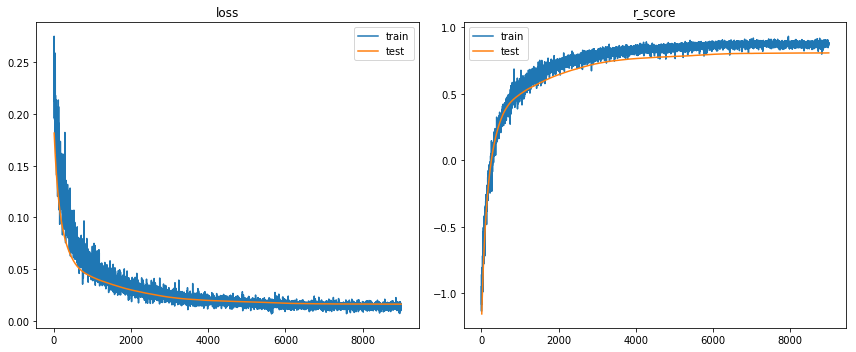

min train loss :  0.0067488057538867
min test loss :  0.016191832721233368
max train r_score :  0.9328458750330173
max test r_score :  0.8078649415544488


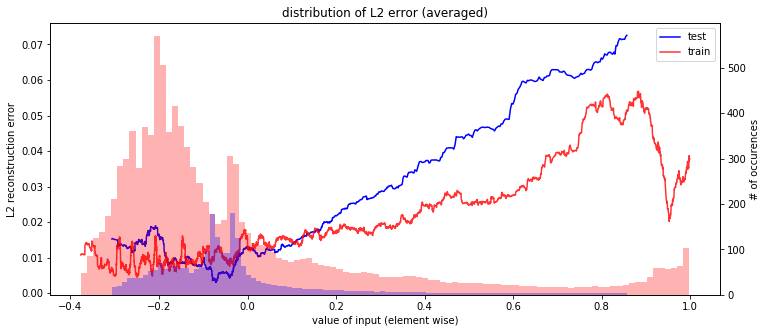

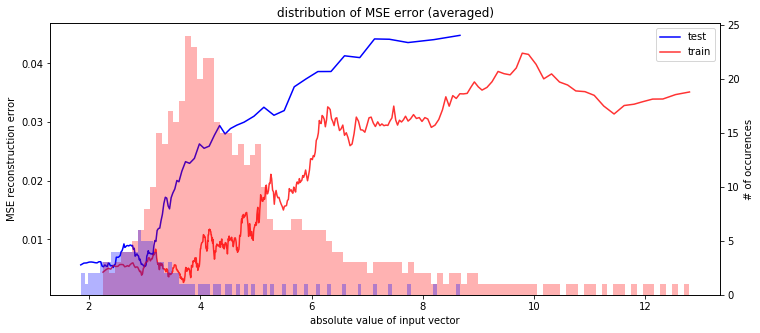

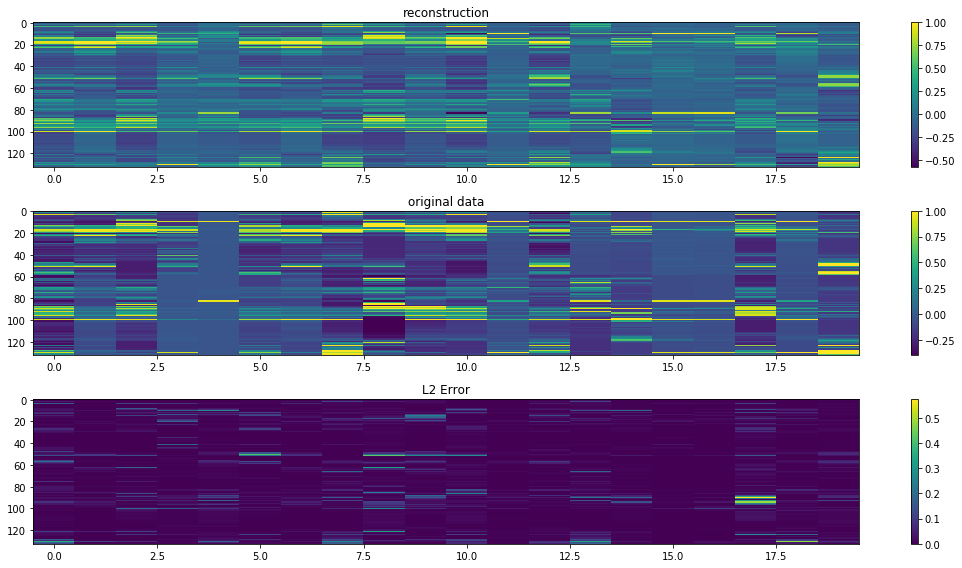

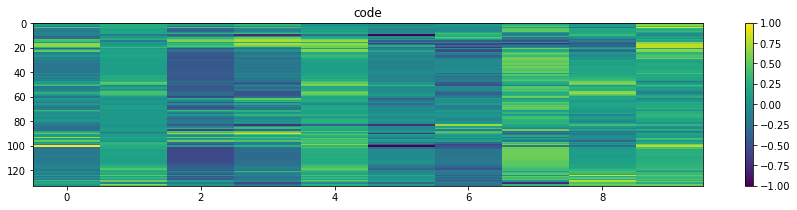

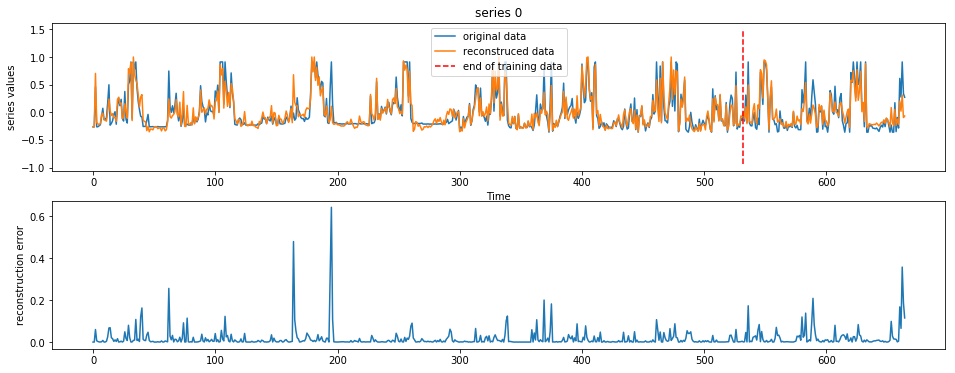

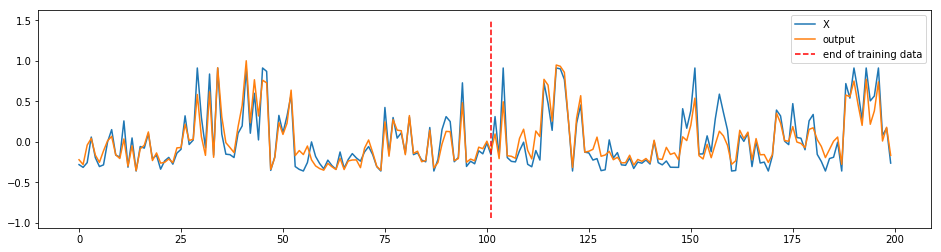

In [796]:
show_results(output_dict)

## Second run for 1000 epochs

In [810]:
output_dict = train_model(model.cuda())


  4%|▍         | 40/1000 [00:04<01:52,  8.53it/s, test_l=0.0162, test_r=0.808, train_l=0.0125, train_r=0.871]


  8%|▊         | 84/1000 [00:09<01:29, 10.23it/s, test_l=0.0162, test_r=0.808, train_l=0.0137, train_r=0.886]


 13%|█▎        | 129/1000 [00:14<01:28,  9.83it/s, test_l=0.0162, test_r=0.808, train_l=0.0142, train_r=0.87]


 17%|█▋        | 169/1000 [00:19<01:54,  7.24it/s, test_l=0.0162, test_r=0.808, train_l=0.0135, train_r=0.879]


 21%|██        | 206/1000 [00:23<01:29,  8.89it/s, test_l=0.0162, test_r=0.808, train_l=0.0149, train_r=0.873] 


 24%|██▍       | 244/1000 [00:28<01:39,  7.61it/s, test_l=0.0162, test_r=0.808, train_l=0.00947, train_r=0.893]


 28%|██▊       | 282/1000 [00:33<01:34,  7.62it/s, test_l=0.0162, test_r=0.808, train_l=0.00862, train_r=0.904]


 32%|███▏      | 320/1000 [00:38<01:24,  8.00it/s, test_l=0.0162, test_r=0.808, train_l=0.00855, train_r=0.869]


 36%|███▌      | 361/1000 [00:43<01:04,  9.93it/s, test_l=0.0161, test_r=0.808, train_l=0.0186, train_r=0.886]


 41%|████      | 408/1000 [00:48<01:19,  7.48it/s, test_l=0.0161, test_r=0.808, train_l=0.0142, train_r=0.88]


 46%|████▌     | 455/1000 [00:52<00:50, 10.81it/s, test_l=0.0162, test_r=0.808, train_l=0.0105, train_r=0.844]


 50%|████▉     | 497/1000 [00:57<01:02,  8.09it/s, test_l=0.0162, test_r=0.808, train_l=0.0124, train_r=0.885]


 54%|█████▎    | 537/1000 [01:01<00:48,  9.51it/s, test_l=0.0162, test_r=0.808, train_l=0.0151, train_r=0.835]


 58%|█████▊    | 579/1000 [01:06<00:42,  9.85it/s, test_l=0.0162, test_r=0.808, train_l=0.0144, train_r=0.889]


 62%|██████▏   | 620/1000 [01:11<01:01,  6.21it/s, test_l=0.0162, test_r=0.808, train_l=0.00908, train_r=0.881]


 66%|██████▌   | 661/1000 [01:16<00:32, 10.41it/s, test_l=0.0162, test_r=0.807, train_l=0.0148, train_r=0.85]


 70%|███████   | 703/1000 [01:21<00:53,  5.53it/s, test_l=0.0163, test_r=0.807, train_l=0.0125, train_r=0.903]


 74%|███████▍  | 740/1000 [01:26<00:34,  7.61it/s, test_l=0.0163, test_r=0.807, train_l=0.0176, train_r=0.854]


 78%|███████▊  | 784/1000 [01:31<00:20, 10.76it/s, test_l=0.0163, test_r=0.807, train_l=0.0148, train_r=0.877]


 83%|████████▎ | 834/1000 [01:35<00:15, 10.74it/s, test_l=0.0163, test_r=0.806, train_l=0.0179, train_r=0.883]


 88%|████████▊ | 882/1000 [01:40<00:10, 10.83it/s, test_l=0.0163, test_r=0.807, train_l=0.0146, train_r=0.857]


 93%|█████████▎| 929/1000 [01:45<00:06, 10.41it/s, test_l=0.0163, test_r=0.806, train_l=0.0115, train_r=0.866]


 98%|█████████▊| 978/1000 [01:49<00:02, 10.44it/s, test_l=0.0163, test_r=0.806, train_l=0.0122, train_r=0.885]


100%|██████████| 1000/1000 [01:51<00:00, 10.76it/s, test_l=0.0163, test_r=0.807, train_l=0.0112, train_r=0.87]

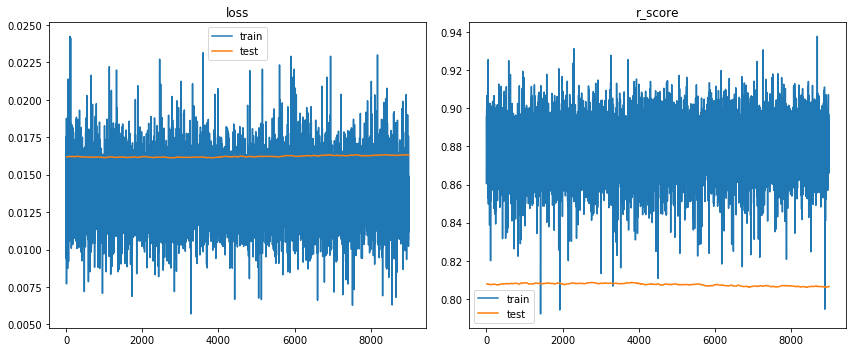

min train loss :  0.005706089548766613
min test loss :  0.016118353232741356
max train r_score :  0.9376659853936138
max test r_score :  0.8087368617415593


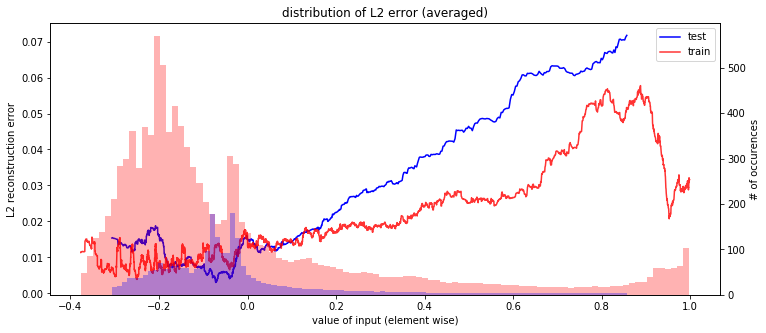

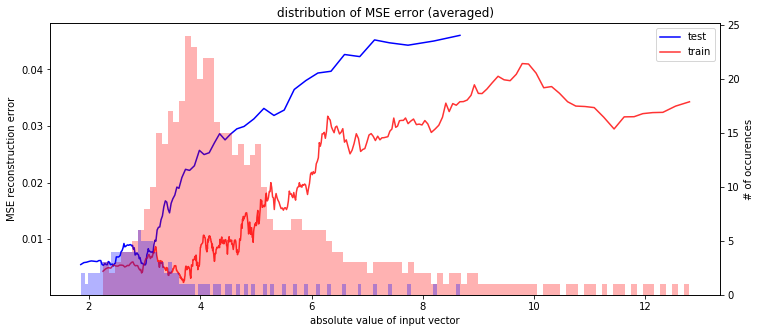

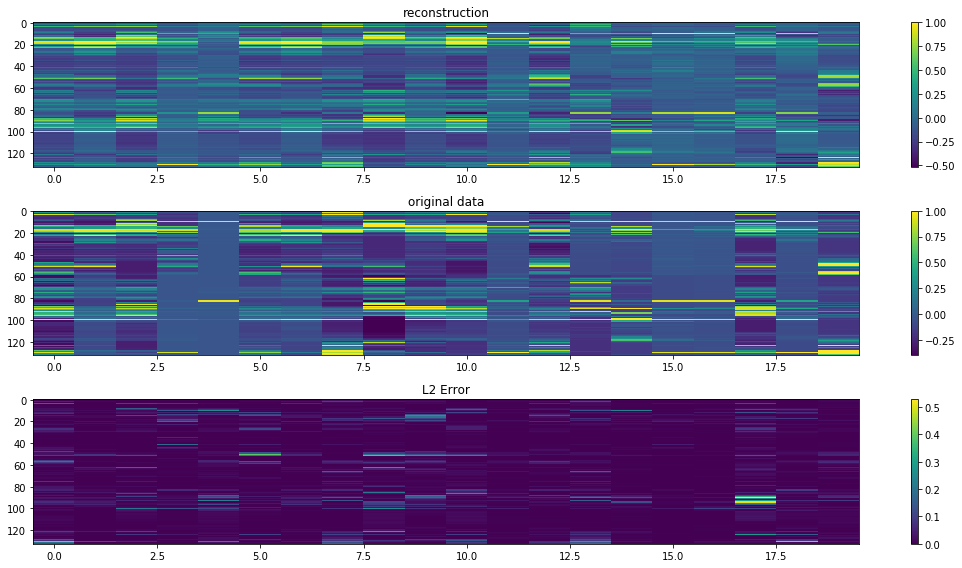

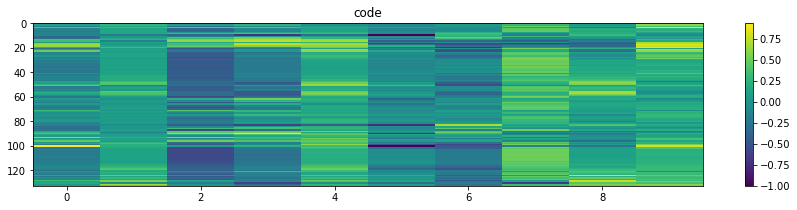

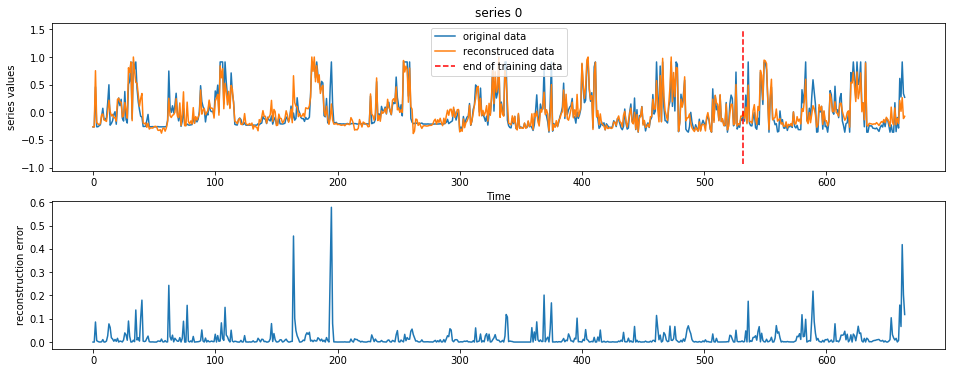

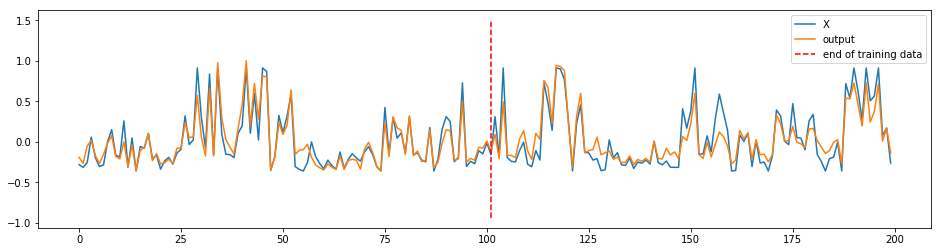

In [811]:
show_results(output_dict)

# Apply the VAE 

In [812]:
# load first mouse
test = mice[9]
df = pd.DataFrame(test['reads_standardized'][:20,:].transpose())
df.columns = test['otus'][:20]
df = pd.DataFrame(winsorize(df, limits=[0.02,0.02], axis=0))
x = df.values
min_max_scaler = preprocessing.StandardScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df = df.clip(-3,3)
df /=3
df.columns = test['otus'][:20]


In [813]:
df.shape

(73, 20)

In [814]:
df.head()

,OTU_1,OTU_2,OTU_3,OTU_4,OTU_5,OTU_6,OTU_7,OTU_8,OTU_9,OTU_10,OTU_11,OTU_12,OTU_13,OTU_14,OTU_15,OTU_16,OTU_17,OTU_18,OTU_19,OTU_20
0,-0.323596,-0.279537,-0.213369,-0.182143,-0.175513,-0.258634,-0.266240,-0.218754,-0.202639,-0.204309,-0.233759,-0.146642,-0.341449,-0.172123,-0.098773,-0.085348,-0.119035,-0.237328,-0.117242,-0.163065
1,-0.195552,-0.278251,-0.213300,-0.177467,-0.171649,-0.258634,-0.266240,-0.207212,-0.152774,-0.198496,-0.232699,-0.031919,-0.333233,0.011282,-0.079848,-0.085348,-0.101571,-0.237330,-0.109946,-0.163065
2,0.107994,-0.210126,-0.212276,-0.182367,-0.068463,-0.256752,-0.203083,-0.114594,-0.024102,-0.151629,-0.205471,0.126012,-0.165973,0.910395,0.041673,-0.085348,0.124766,-0.235886,-0.017547,-0.163065
3,0.238759,-0.062386,-0.148259,-0.161461,-0.115810,-0.215980,-0.064107,-0.172123,0.077406,-0.157789,-0.156326,-0.045280,0.111543,0.369010,-0.057513,-0.085348,-0.081437,-0.208755,-0.118076,-0.159031
4,0.188957,0.006796,0.048190,-0.182367,-0.149739,-0.219093,0.027128,-0.160538,0.076064,-0.134532,-0.077635,-0.025000,0.086387,0.249163,-0.049768,-0.085348,-0.119339,-0.216785,-0.118076,-0.161656


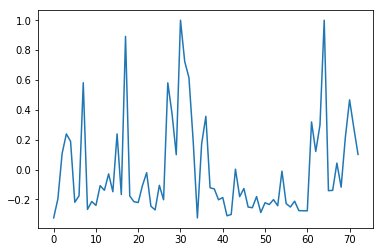

In [815]:
plt.plot(df['OTU_1'])

In [816]:
model = model.cpu()

In [817]:
code_df, rec_df = model(torch.Tensor(df.values))

In [818]:
rec_df = rec_df.data.numpy()

In [819]:
rec_df

array([[-0.30537137, -0.26541469, -0.24045667, ..., -0.19468713,
        -0.10501391, -0.14031361],
       [-0.24106255, -0.27371708, -0.22602636, ..., -0.2043706 ,
        -0.09024751, -0.17968304],
       [-0.00960587, -0.27301568, -0.20081598, ..., -0.26499483,
         0.04069126, -0.3310567 ],
       ...,
       [ 0.00845681, -0.01776931, -0.19135374, ...,  0.00179021,
        -0.18899542,  0.75072646],
       [ 0.00665008,  0.04781838, -0.13792862, ...,  0.07857063,
        -0.20936988,  0.569582  ],
       [-0.07668639, -0.002886  , -0.13146916, ...,  0.0520395 ,
        -0.15727684,  0.3592093 ]], dtype=float32)

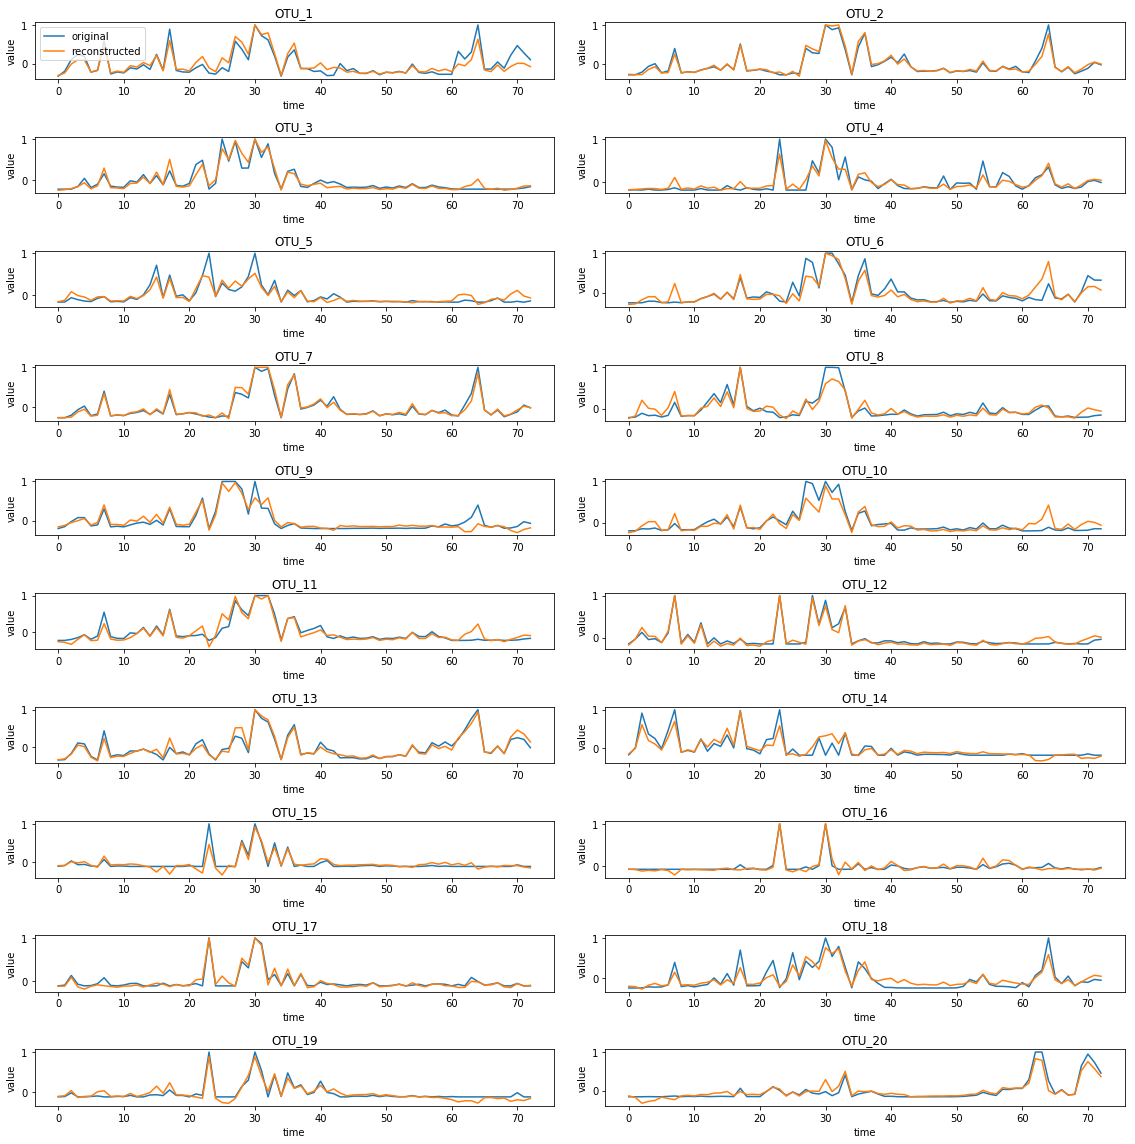

In [820]:
fig, ax = plt.subplots(10,2, figsize=(16,16))

axs = ax.flatten()
i=0    
axs[i].plot(df.iloc[:,i], label='original')
axs[i].plot(rec_df[:,i], label='reconstructed')
axs[i].set_xlabel('time')
axs[i].set_ylabel('value')
axs[i].set_title('OTU_{}'.format(i+1))
axs[i].legend()
for i in range(1,20):    
    axs[i].plot(df.iloc[:,i], label='original')
    axs[i].plot(rec_df[:,i], label='reconstructed')
    axs[i].set_xlabel('time')
    axs[i].set_ylabel('value')
    axs[i].set_title('OTU_{}'.format(i+1))

plt.tight_layout()

In [821]:
error_df = (rec_df-df).abs()

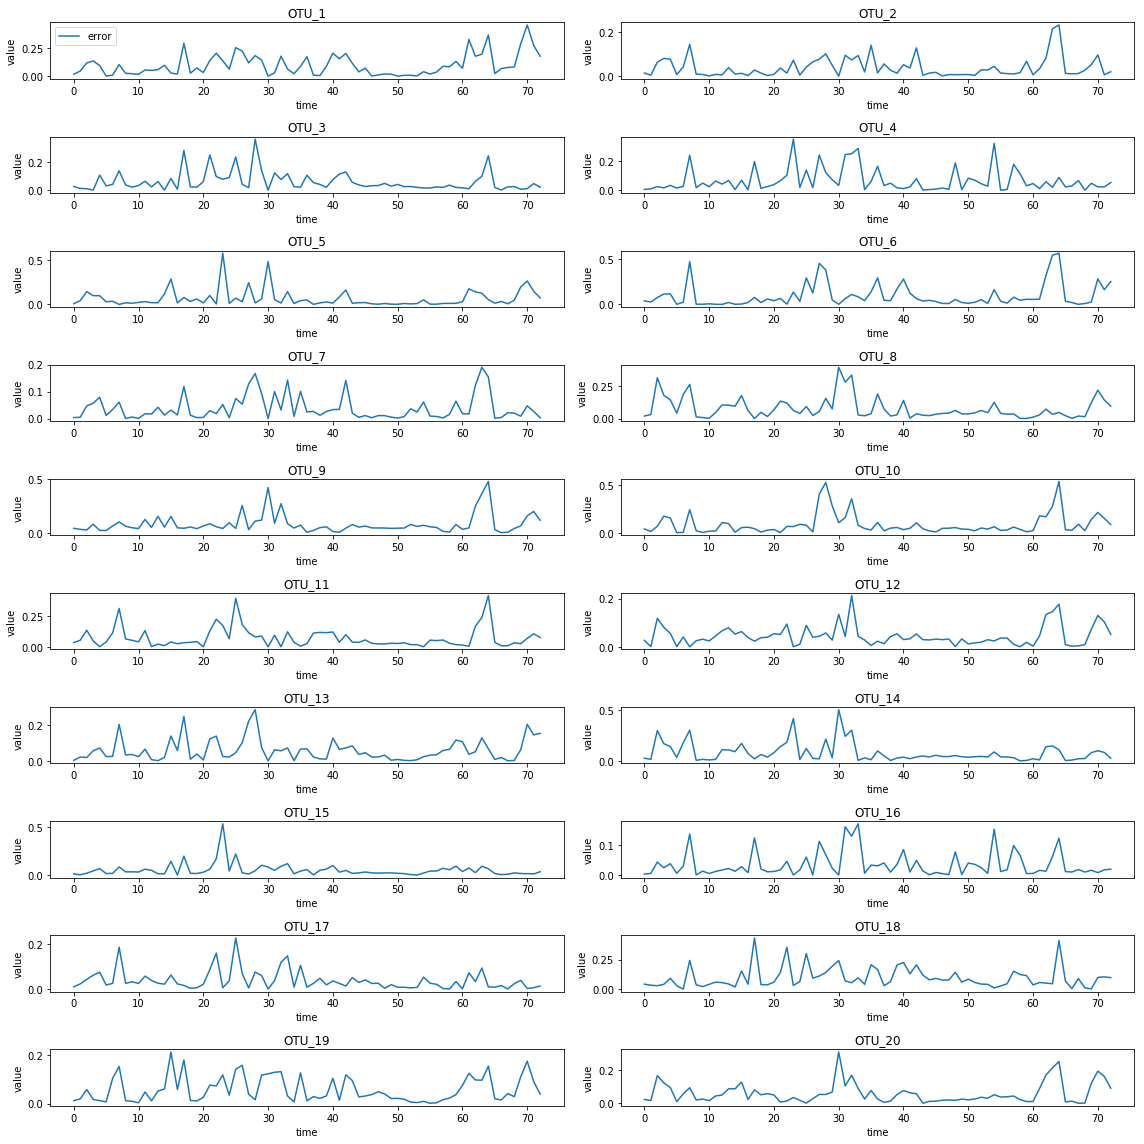

In [822]:
fig, ax = plt.subplots(10,2, figsize=(16,16))

axs = ax.flatten()
i=0    
axs[i].plot(error_df.iloc[:,i], label='error')
axs[i].set_xlabel('time')
axs[i].set_ylabel('value')
axs[i].set_title('OTU_{}'.format(i+1))
axs[i].legend()
for i in range(1,20):    
    axs[i].plot(error_df.iloc[:,i], label='error')
    axs[i].set_xlabel('time')
    axs[i].set_ylabel('value')
    axs[i].set_title('OTU_{}'.format(i+1))

plt.tight_layout()

## Time Analysis

In [827]:
i=2
test = mice[i]
df = pd.DataFrame(test['reads_standardized'][:20,:].transpose())
df.columns = test['otus'][:20]
df = pd.DataFrame(winsorize(df, limits=[0.02,0.02], axis=0))
x = df.values
min_max_scaler = preprocessing.StandardScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df = df.clip(-3,3)
df /=3
df.columns = test['otus'][:20]


In [828]:
df.head()

,OTU_1,OTU_2,OTU_3,OTU_4,OTU_5,OTU_6,OTU_7,OTU_8,OTU_9,OTU_10,OTU_11,OTU_12,OTU_13,OTU_14,OTU_15,OTU_16,OTU_17,OTU_18,OTU_19,OTU_20
0,-0.243569,-0.185350,-0.223210,-0.266123,-0.202144,-0.269107,-0.231788,-0.152953,-0.124629,-0.209524,-0.103684,-0.278338,-0.268677,-0.224201,-0.103262,-0.263040,-0.264747,-0.139175,-0.210959,-0.159936
1,-0.243402,-0.185223,-0.223202,-0.266123,-0.202143,-0.269107,-0.231756,-0.152950,-0.108582,-0.209521,-0.100633,-0.278338,-0.268751,-0.224217,-0.103281,-0.263040,-0.264747,-0.139175,-0.210962,-0.159936
2,0.381046,0.258174,-0.089451,-0.264398,-0.177577,-0.268368,0.149064,0.060965,-0.127846,1.000000,-0.103771,0.050732,1.000000,0.916613,1.000000,-0.259776,-0.264747,-0.139175,-0.167579,-0.159936
3,-0.242371,-0.149345,-0.214524,-0.265975,-0.200569,-0.269053,-0.204784,-0.133450,-0.104314,-0.126809,-0.103771,-0.251104,-0.151760,-0.120471,-0.041412,-0.262961,-0.264747,-0.139175,-0.205213,-0.159936
4,-0.241088,-0.127283,-0.195672,-0.265431,-0.200492,-0.268645,-0.185342,-0.109273,-0.086691,-0.183938,-0.092017,-0.219150,-0.182902,-0.133506,-0.074131,-0.261300,-0.260258,-0.139175,-0.195585,-0.159936


In [833]:
code_df, _ = model.cpu()(torch.Tensor(df.values))

In [837]:

code_df = code_df.cpu().data.numpy()

In [839]:
pca = PCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(code_df))

In [842]:
transformed.shape

(75, 2)

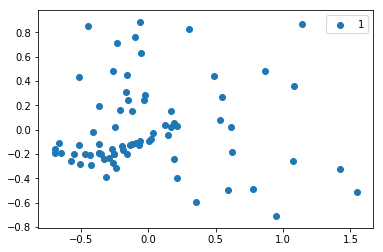

In [843]:
plt.scatter(transformed[0], transformed[1])

plt.legend()
plt.show()